# A Bayesian approach to model 'fitting'
### August George - 11/2020
#### Zuckerman Lab - OHSU

These notes were prepared for a class presentation. You will need install the pyMC3 and arviz python libraries to run it.  

### Motivation

Suppose we do an experiment and observe this data. What model do we expect?

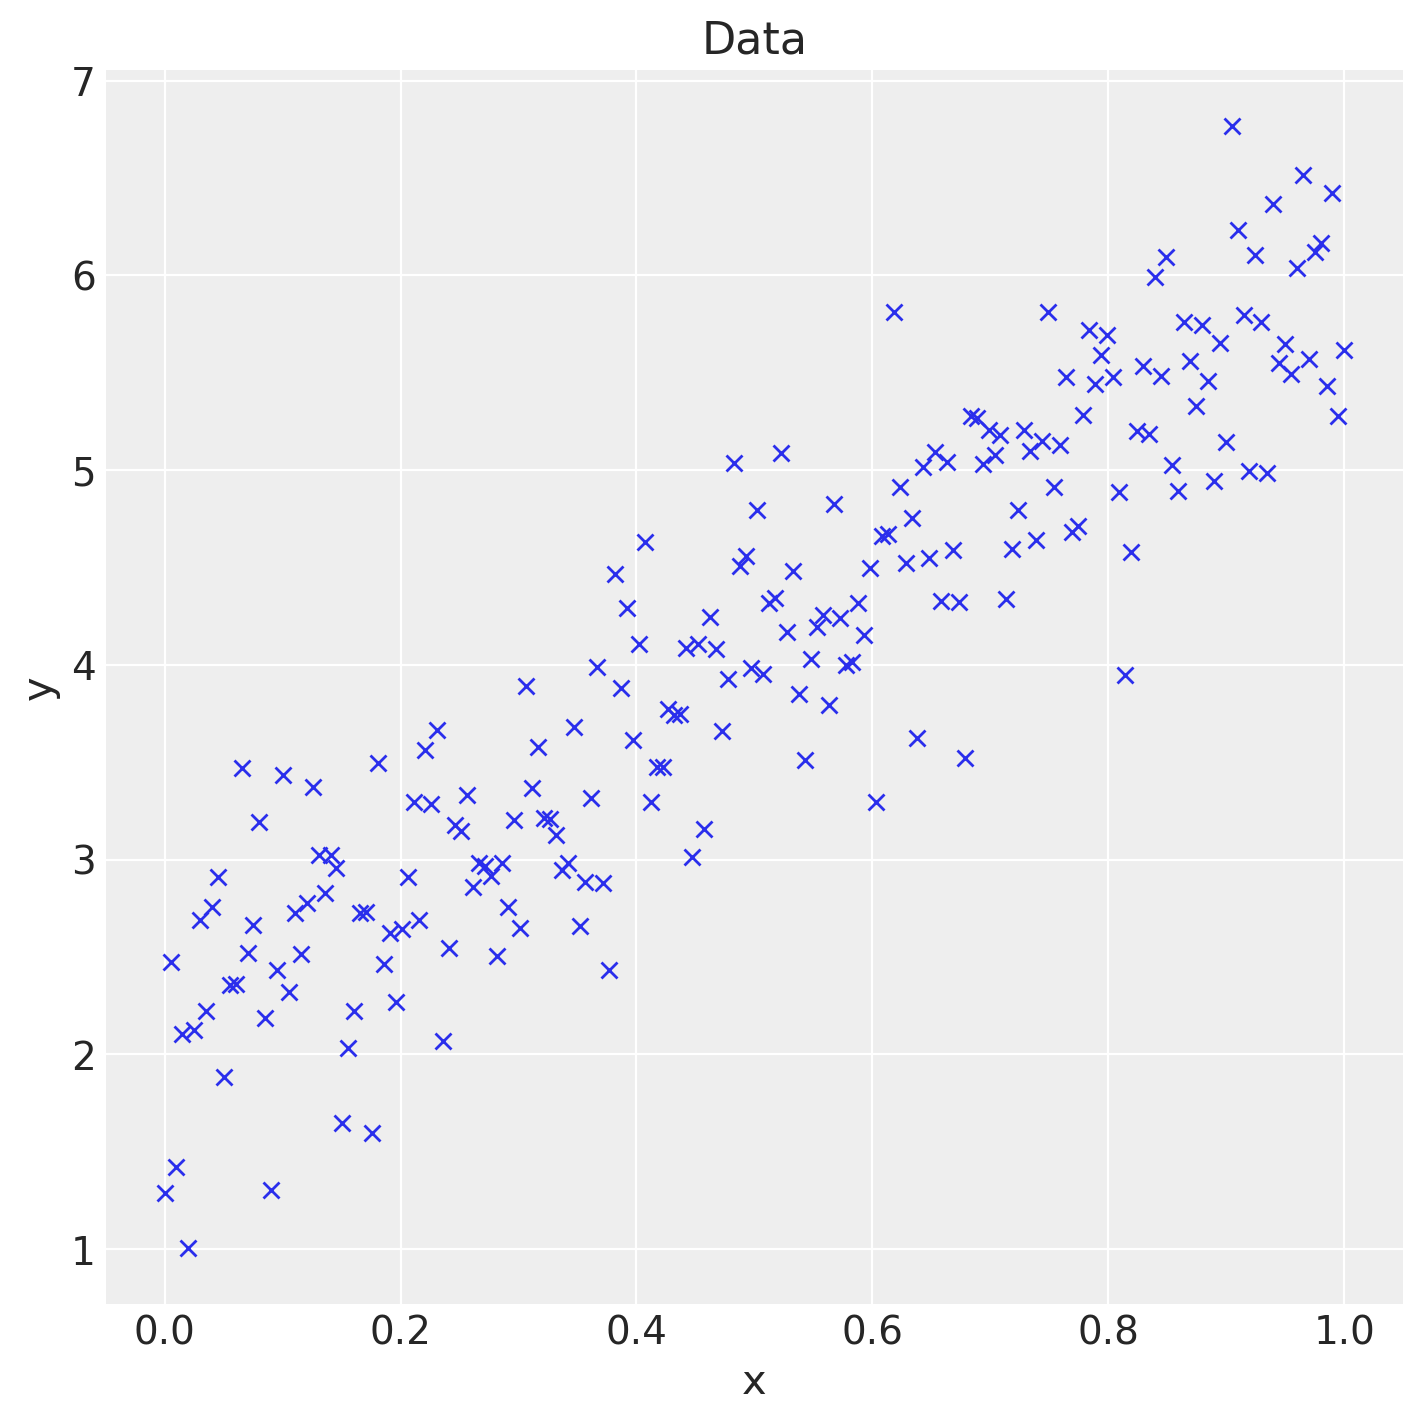

In [26]:
from IPython.display import Image
Image(filename="observed_data.png", width = 400, height = 400)

### Motivation
How can we find the parameters for this model (i.e slope and intercept)?
  

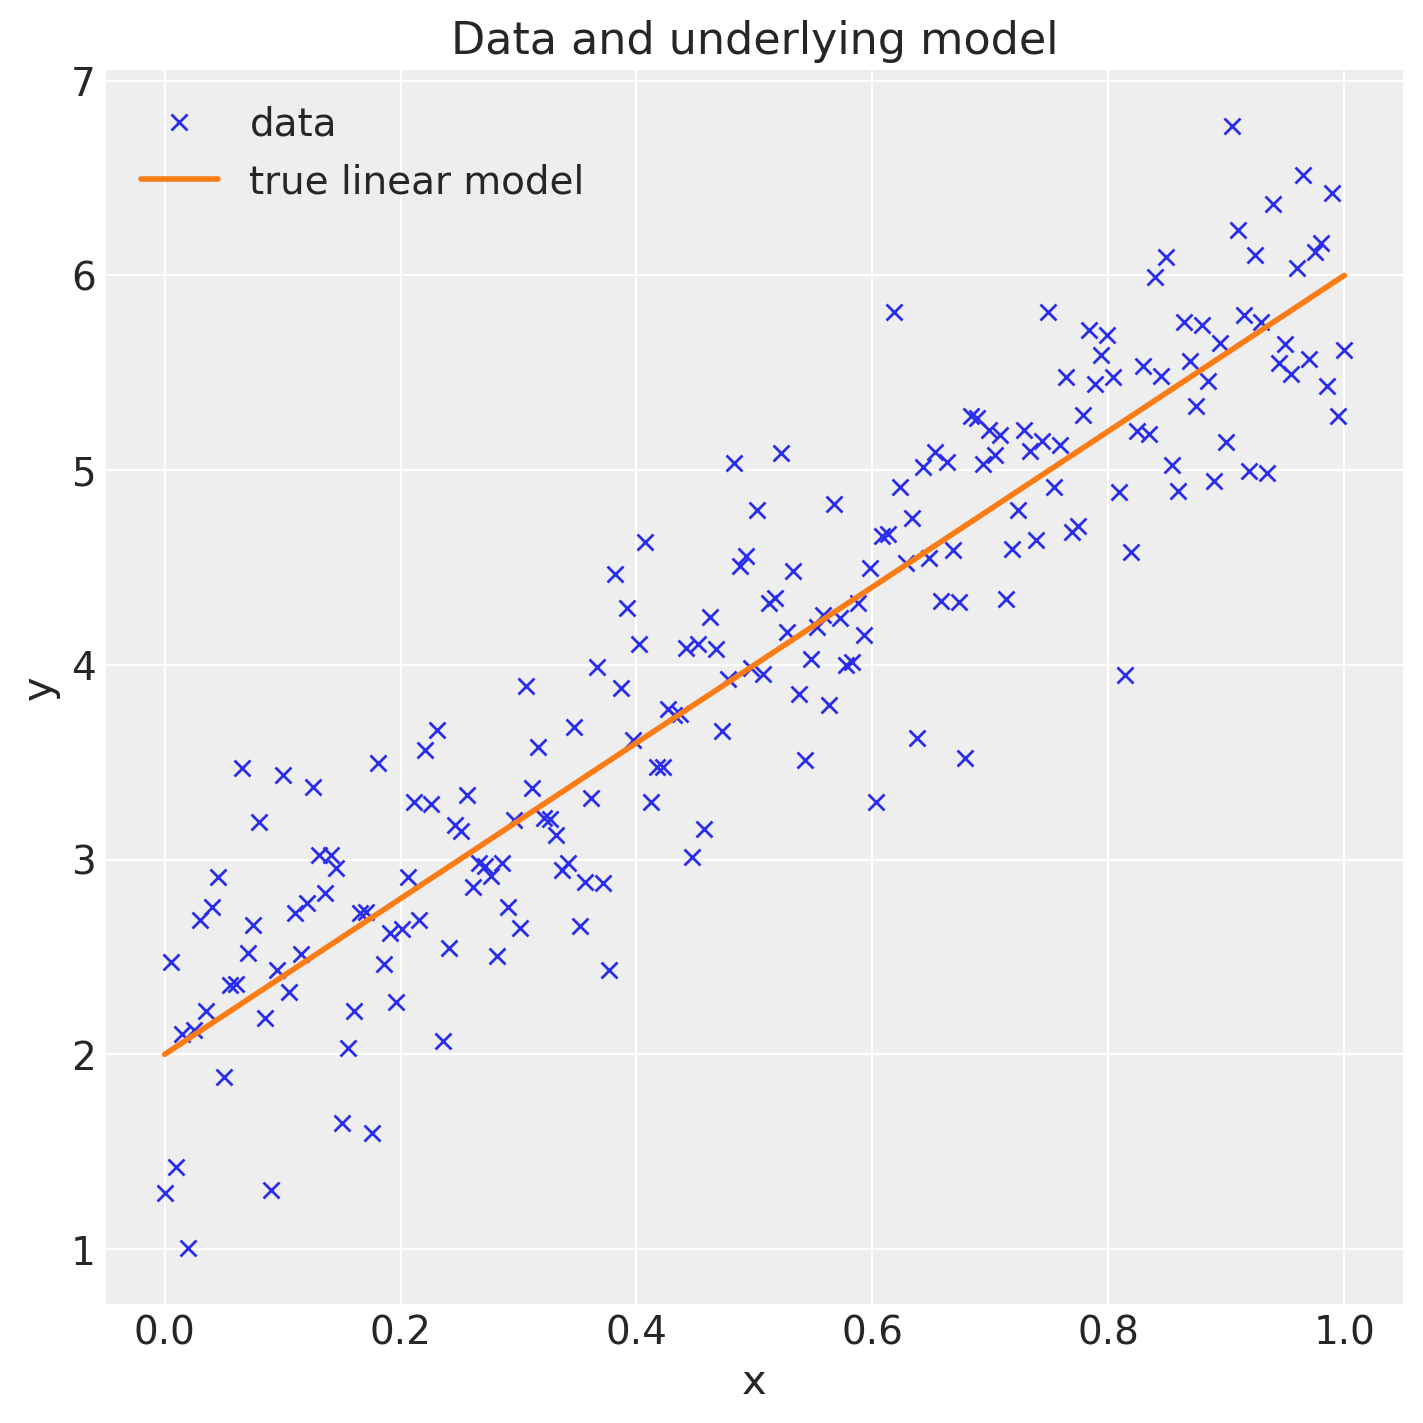

In [25]:
Image(filename="linear_model.png", width = 400, height = 400)

### Fitting a model to data

One common method is linear regression

+ Provides a point estimate of the best fit for the parameters (MLE)

An alternative is Bayesian inference. 

+ Provides a *distribution* for each model parameter

### Bayes' Theorem intuition (review)

Probability of 2 events, A and B

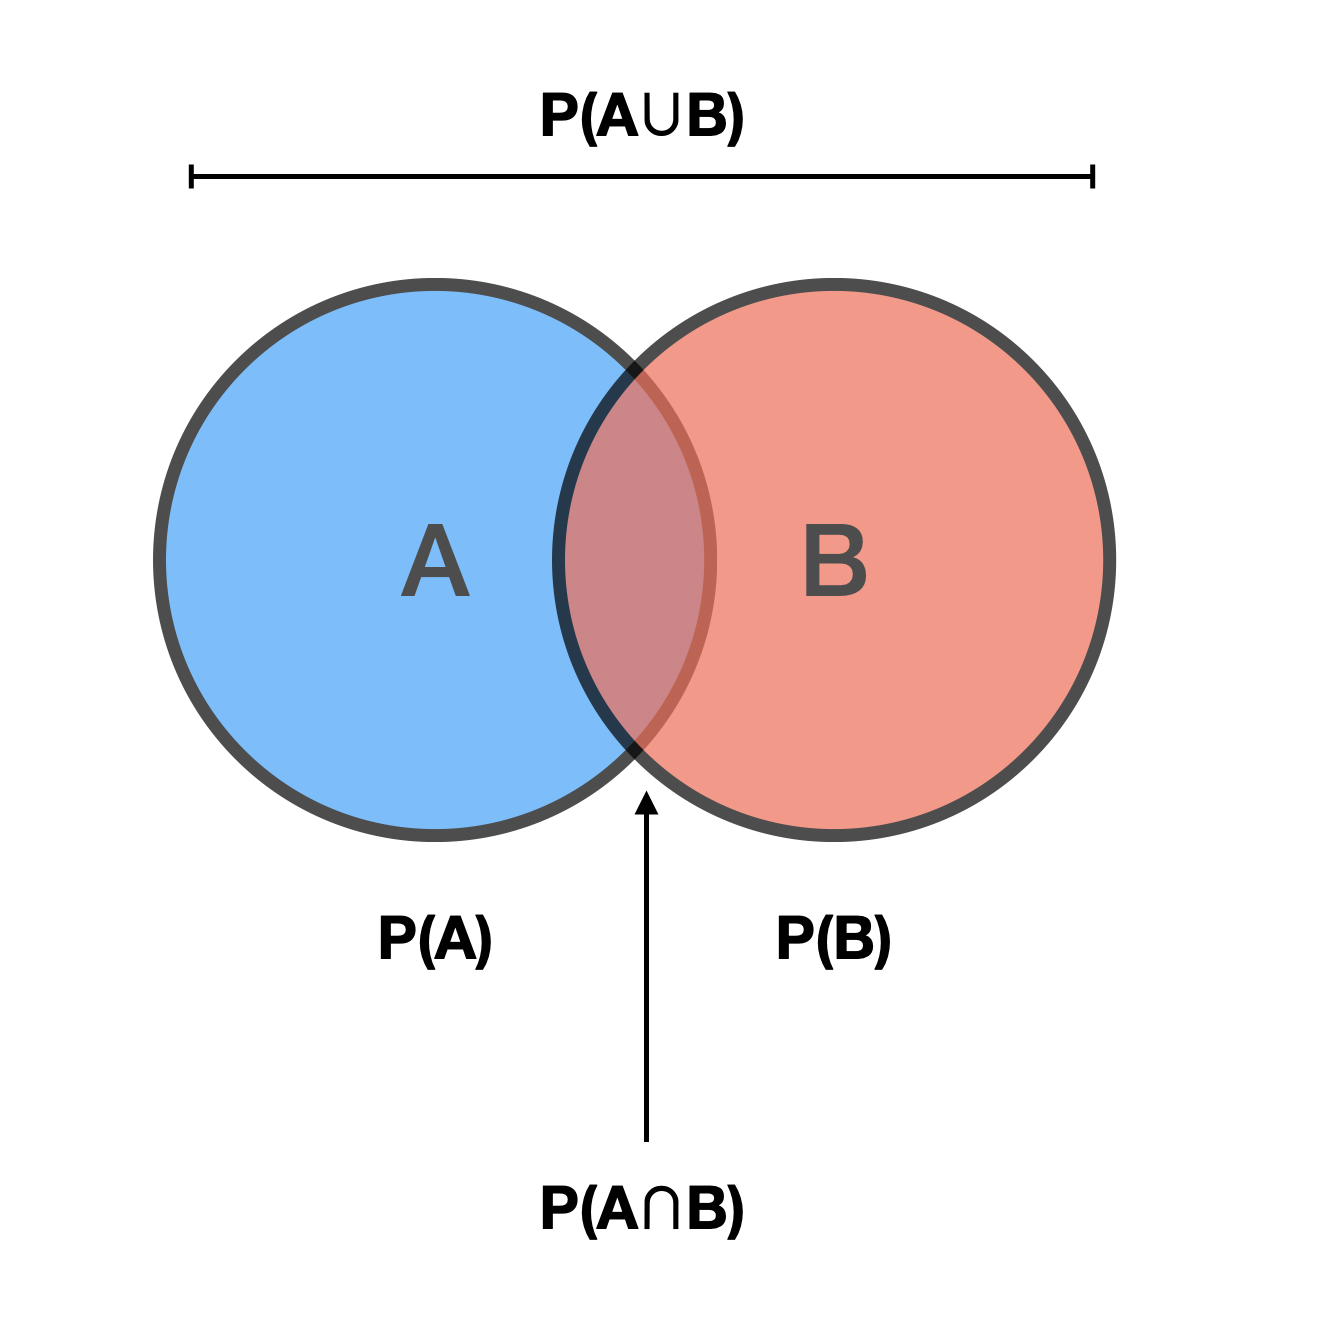

In [3]:
Image(filename="bayes_1.png", width = 400, height = 400)

Probability of event A given B happened: $P(A|B) = \dfrac{P(A\cap B)}{P(B)}$

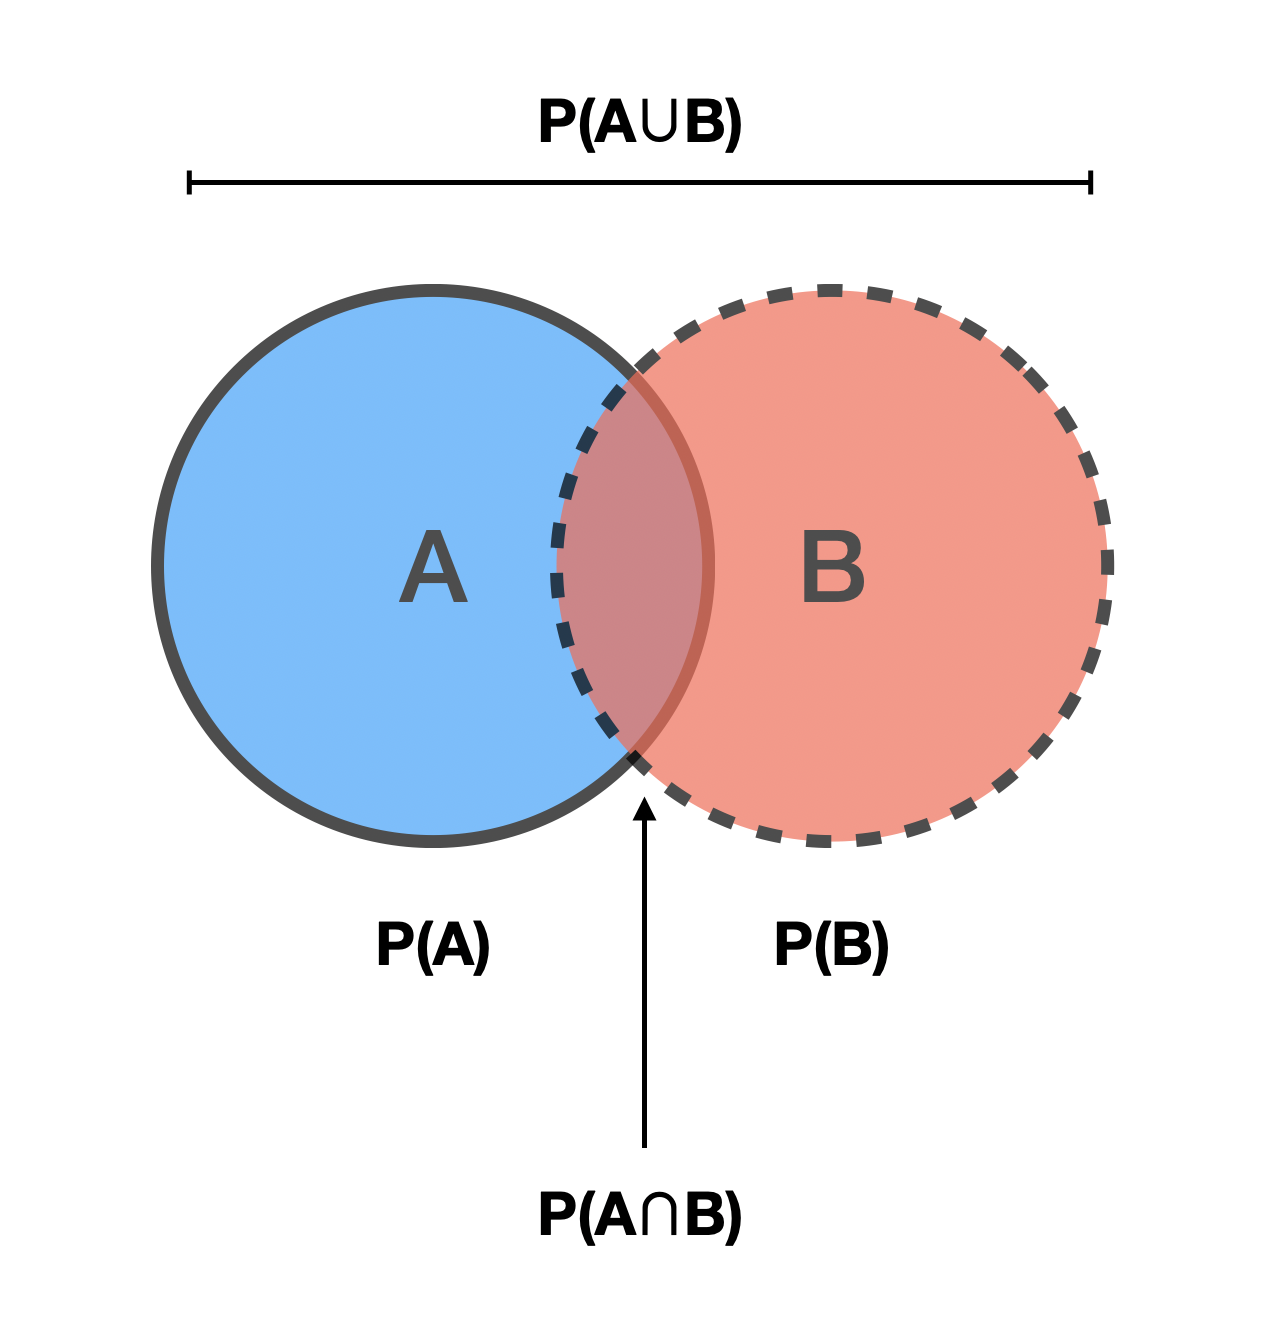

In [4]:
Image(filename="bayes_2.png", width = 400, height = 400)

### Bayes' Theorem intuition
Probability of event B given A happened: $P(B|A) = \dfrac{P(A\cap B)}{P(A)}$

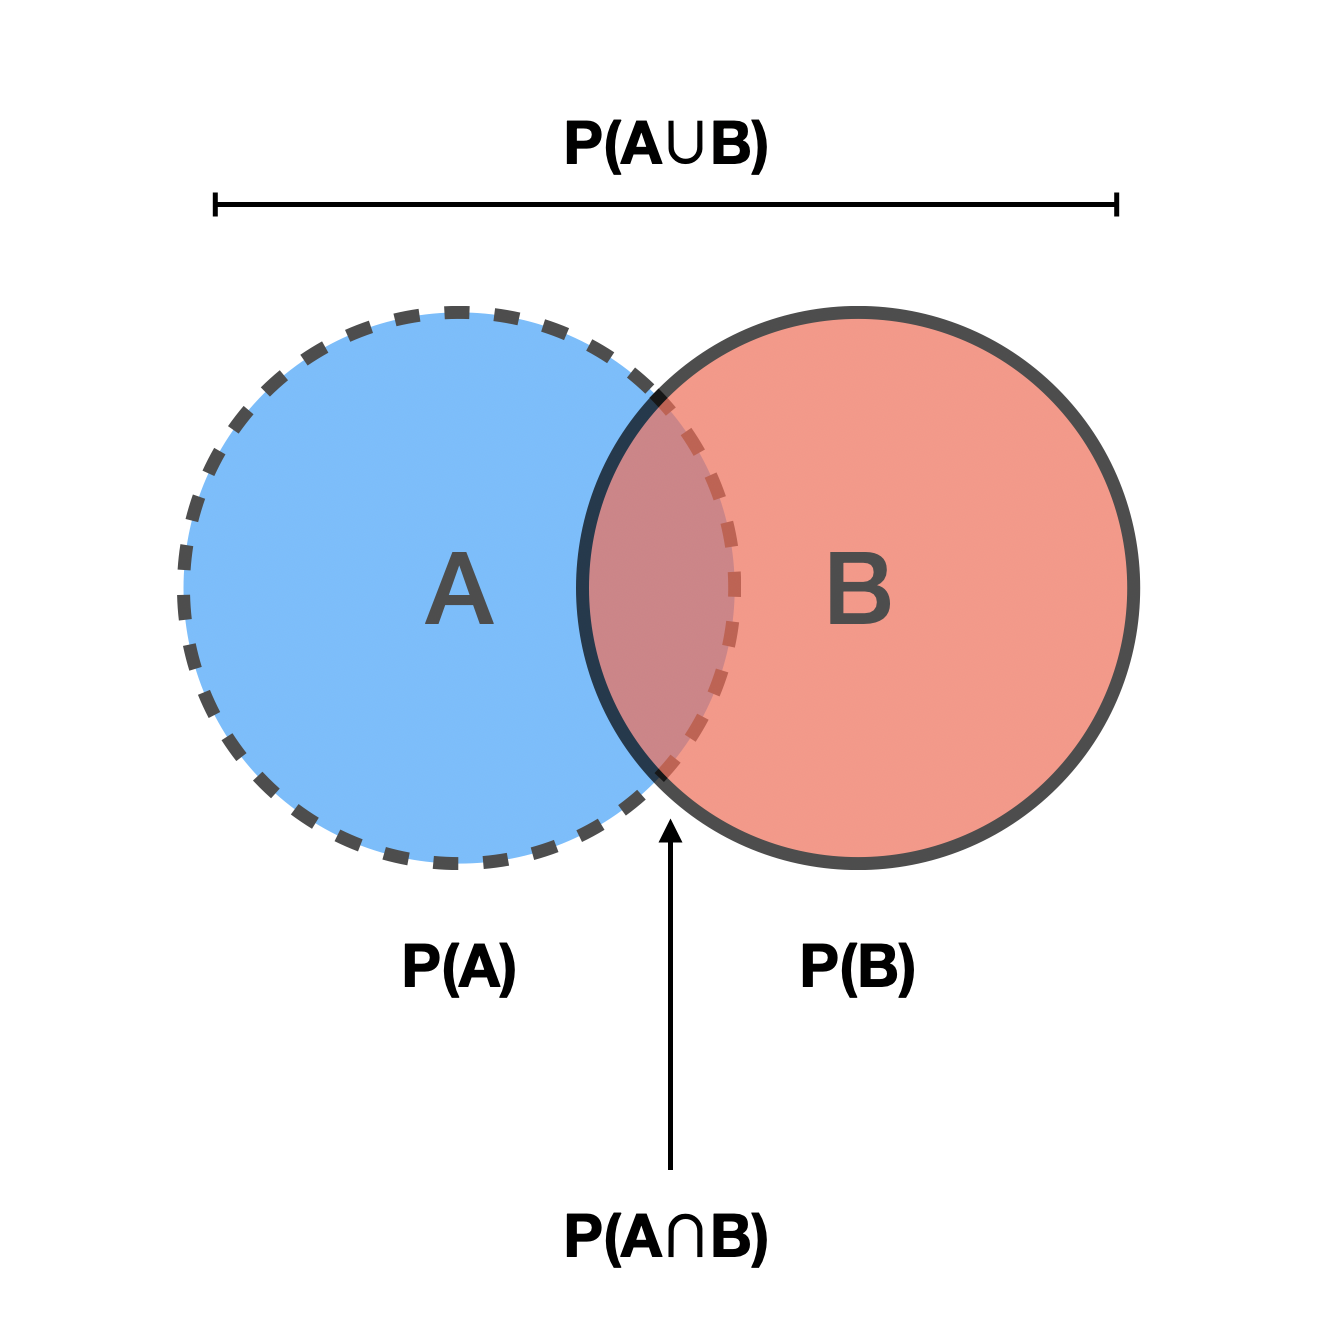

In [5]:
Image(filename="bayes_3.png", width = 400, height = 400)

### Bayes' Theorem intuition

$P(A|B) = \dfrac{P(A\cap B)}{P(B)}  \longrightarrow P(A\cap B) = P(A|B) \cdot P(B)$ 

*and*

$P(B|A) = \dfrac{P(A\cap B)}{P(A)}  \longrightarrow P(A\cap B) = P(B|A) \cdot P(A)$

$ \Rightarrow $ **Bayes' Theorem:** $P(B|A) = \dfrac{P(A|B) \cdot P(B)}{P(A)}$

### Bayes' Theorem 


Can rewrite using probability distributions: $p(\theta | \mathrm{data}) = \dfrac{\mathcal{p}(\mathrm{data} | \theta ) \cdot p(\theta)}{p(\mathrm{data})}$


Also as: $posterior = \dfrac{likelihood \cdot prior}{evidence}$

### Bayes' Theorem 

$posterior = \dfrac{likelihood \cdot prior}{evidence}$

**posterior**, $p(\theta | \mathrm{data})$: probability distribution of the model parameters given the data set

**likelihood**, $\mathcal{p}(\mathrm{data} | \theta )$: probability distribution of the data given a set of parameters

**prior**, $p(\theta)$: probability distribution of the parameters - before using the data

**evidence**, $p(\mathrm{data})$: probability distribution of the data - before using the parameters

### Model 'fitting' w/ Bayes' Theorem

We want to find the posterior, the *distribution* of parameters given the data set. 

Calculating this directly is often difficult because of the evidence term:
$p(\mathrm{data}) = {\displaystyle \int_{\theta}^{} p(\mathrm{data} | \theta ) p(\theta)  \ \mathrm{d}\theta }$

Alternative form of **Bayes' Theorem:** $p(\theta | \mathrm{data}) \propto p(\mathrm{data} | \theta ) \cdot p(\theta)$

One way to find the posterior is to use Markov Chain Monte Carlo sampling

### Markov chain Monte Carlo (MCMC)

One approach is to generate a Markov chain with a stationary (equilibrium) distribution that is proportional to the desired (i.e. $p(\theta | \mathrm{data})$) distribution. 

With enough samples, this Markov chain will be proportional to the desired distribution. 

A common method is the random walk Metropolis-Hastings algorithm.


### Random walk Metropolis-Hastings Monte Carlo 
<font size="4"> 

1. Intialization: Choose initial $\theta_{t=0}$ 
2. For $t = 1,...,m$:  
    1. Select canditate $\theta^{*}$ from a symmetric (e.g. Gaussian) distribution: $q(\theta^{*}|\theta_{t-1})$
    2. Calculate acceptance ratio: $\alpha = \dfrac{p(\mathrm{data} | \theta^{*} ) \cdot p(\theta^{*})}{p(\mathrm{data} | \theta_{t-1} ) \cdot p(\theta_{t-1})}$
    3. For $\alpha \geq 1$:
        1. accept candidate: $\theta_{t} \leftarrow \theta^*$
       
       For  $0 < \alpha < 1$:
        1. accept candidate: $\theta_{t} \leftarrow \theta^*$ with probability $\alpha$
        2. reject candidate: $\theta_{t} \leftarrow \theta_{t-1}$ with probability $1-\alpha$

**Note:** This will generate a chain (list) of parameter values. The distribution of these values is proportional to the posterior distribution. 
    
</font> 

### Linear regression example using Bayes' Theorem

We want to find the slope, intercept, and noise *distributions* that best fit the data. 

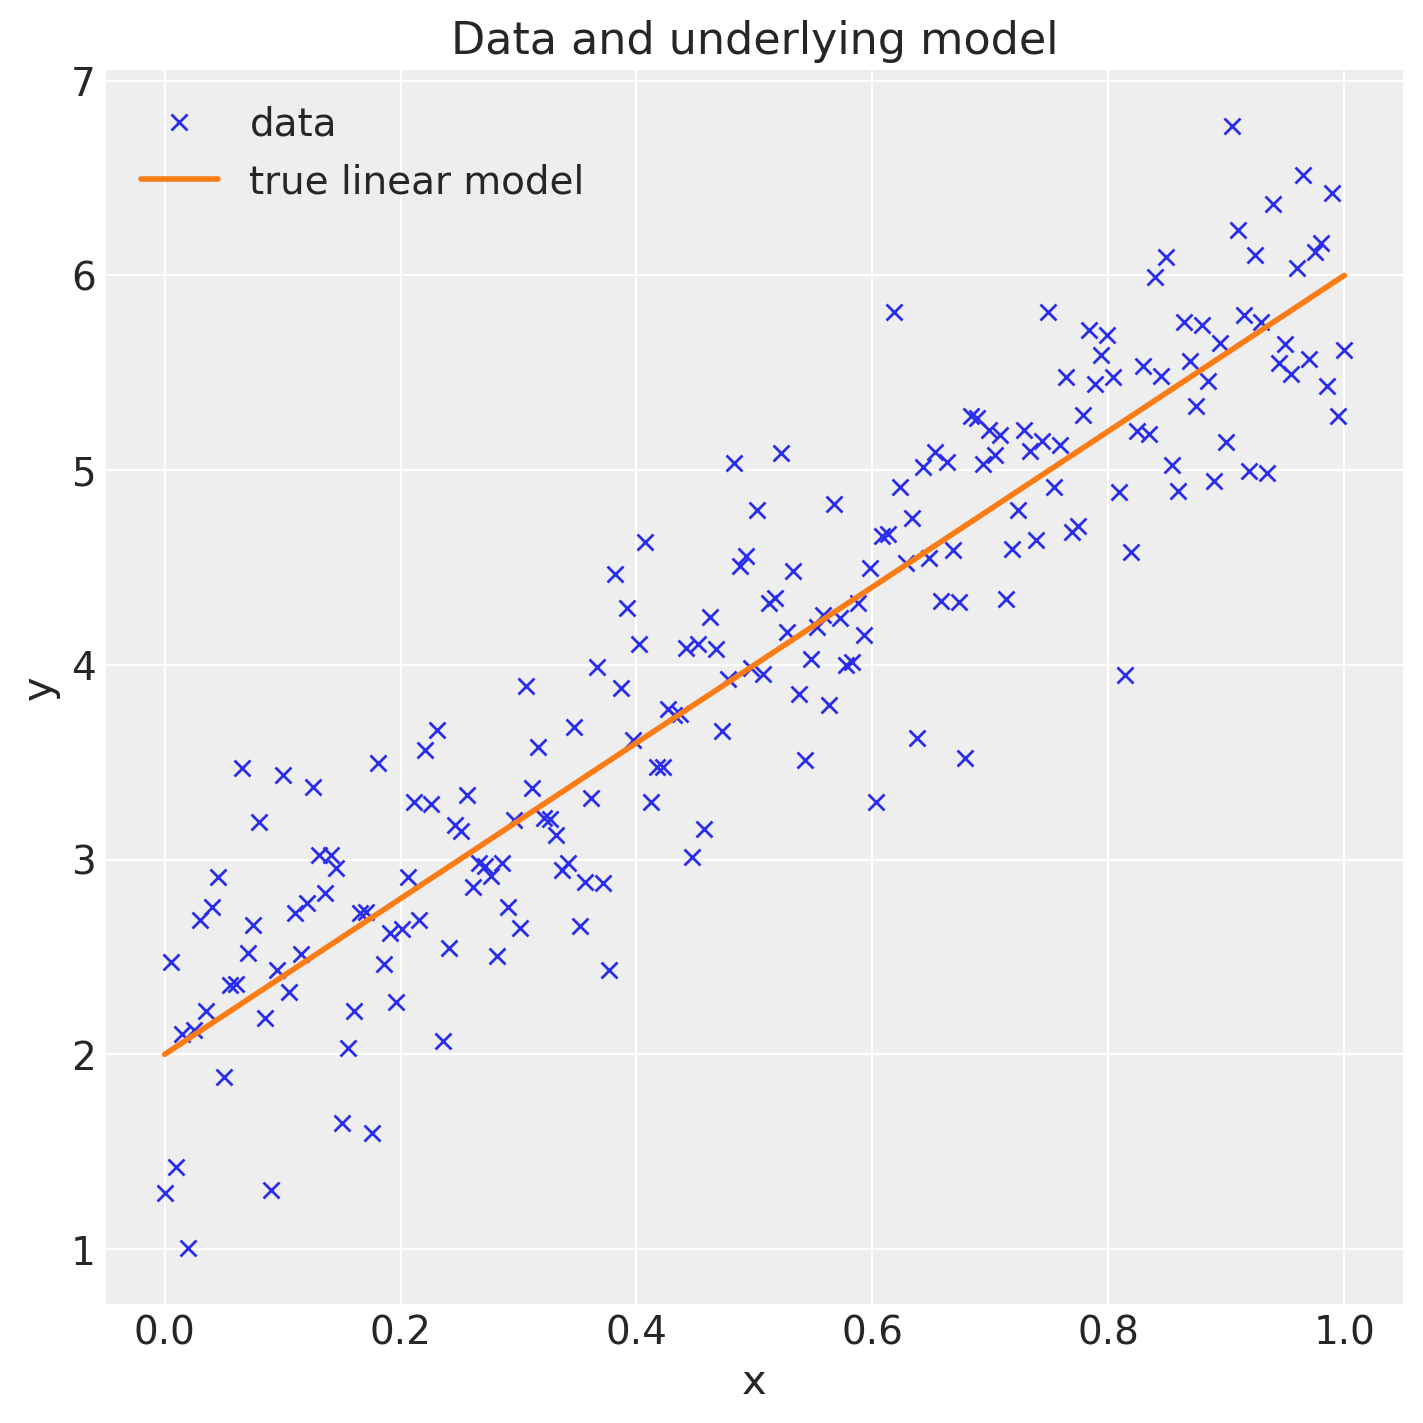

In [6]:
Image(filename="linear_model.png", width = 400, height = 400)

### Linear regression example using Bayes' Theorem

Assumed model: $y_{i} = (ax_{i} + b) + \epsilon_{i}$, 

where $\epsilon$ is drawn from a Normal distribution: $N(\mu_{\epsilon}=0, \sigma_{\epsilon}=\sigma_{\mathrm{True}})$.

Parameters we want to estimate, $\theta = (a, b, \sigma_{\mathrm{True}})$

### Linear regression example using Bayes' Theorem

Priors: Choose distributions, $p(\theta) = p(a)\cdot p(b) \cdot p(\sigma_{\epsilon})$ 

<font size="6"> 
Likelihood: $p(\mathrm{data} | \theta ) = p(y | (a,b,\sigma_{\epsilon}) )$ 
$ = \prod_{i} p(y_{i} | (a,b,\sigma_{\epsilon}) = \prod_{i} \dfrac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{1}{2} \left(\frac{y_{i}-(ax_{i}+b)}{\sigma}\right)^2 }$
</font> 

Posterior: $p(\theta | \mathrm{data}) \propto p(\mathrm{data} | \theta ) \cdot p(\theta)$

Use MCMC to sample from posterior.

### Useful definitions:

##### Gaussian distribution: $p(x) = \dfrac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{1}{2} \left(\frac{x-\mu}{\sigma}\right)^2 }$

### Code example:

Using Python with the pyMC3 library for Bayesian inference. 

**pyMC3 code example reference** https://docs.pymc.io/notebooks/GLM-linear.html

In [7]:
### Import libraries
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from pymc3 import  *
import warnings
warnings.filterwarnings('ignore')


### Set display options
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [8]:
def generate_data(slope=4, intercept=2, sigma=0.5, data_size=200):
    
    ### True parameters for linear model
    true_slope = slope    
    true_intercept = intercept
    true_sigma = sigma

    ### Generate synthetic data 
    size = data_size
    x = np.linspace(0, 1, size)
    true_regression_line = true_intercept + true_slope * x  # y = a + b*x
    y = true_regression_line + np.random.normal(scale=true_sigma, size=size)  # add noise
    return (x,y,true_regression_line)

In [9]:
def sampler(x,y, prior = 'normal', n_samples=200, chains=3, v=True):
    
    ### Construct model using pyMC3
    with Model() as model: 

        ### Define priors
        if prior == 'normal':
            sigma = Lognormal('sigma', 0, sigma=20)
            Intercept = Normal('Intercept', 0, sigma=20)
            x_coeff = Normal('slope', 0, sigma=20)
        elif prior == 'uniform':
            sigma = Uniform('sigma', 0,1)
            Intercept = Uniform('Intercept',-5, 5)
            x_coeff = Uniform('slope', -5, 5)
            
        ### Define likelihood
        likelihood = Normal('y', mu=Intercept + x_coeff * x,
                            sigma=sigma, observed=y)
        ### Inference
        if v:
            trace = sample(n_samples, chains=chains, tune=2000) # draw 3000 posterior samples using NUTS (MCMC w/ gradient) sampling
        else: 
            trace = sample(n_samples, chains=chains, tune=2000, progressbar=False) # draw 3000 posterior samples using NUTS (MCMC w/ gradient) sampling
        
    return trace

In [21]:
# Linear model (example 1) 
# data points = 200, slope = 4, intercept = 2, sigma = 0.5, prior -> normal distributions

x,y,y_true = generate_data()
trace = sampler(x,y, chains = 3)

Sampling 3 chains, 0 divergences: 100%|██████████| 6600/6600 [00:02<00:00, 2309.13draws/s]


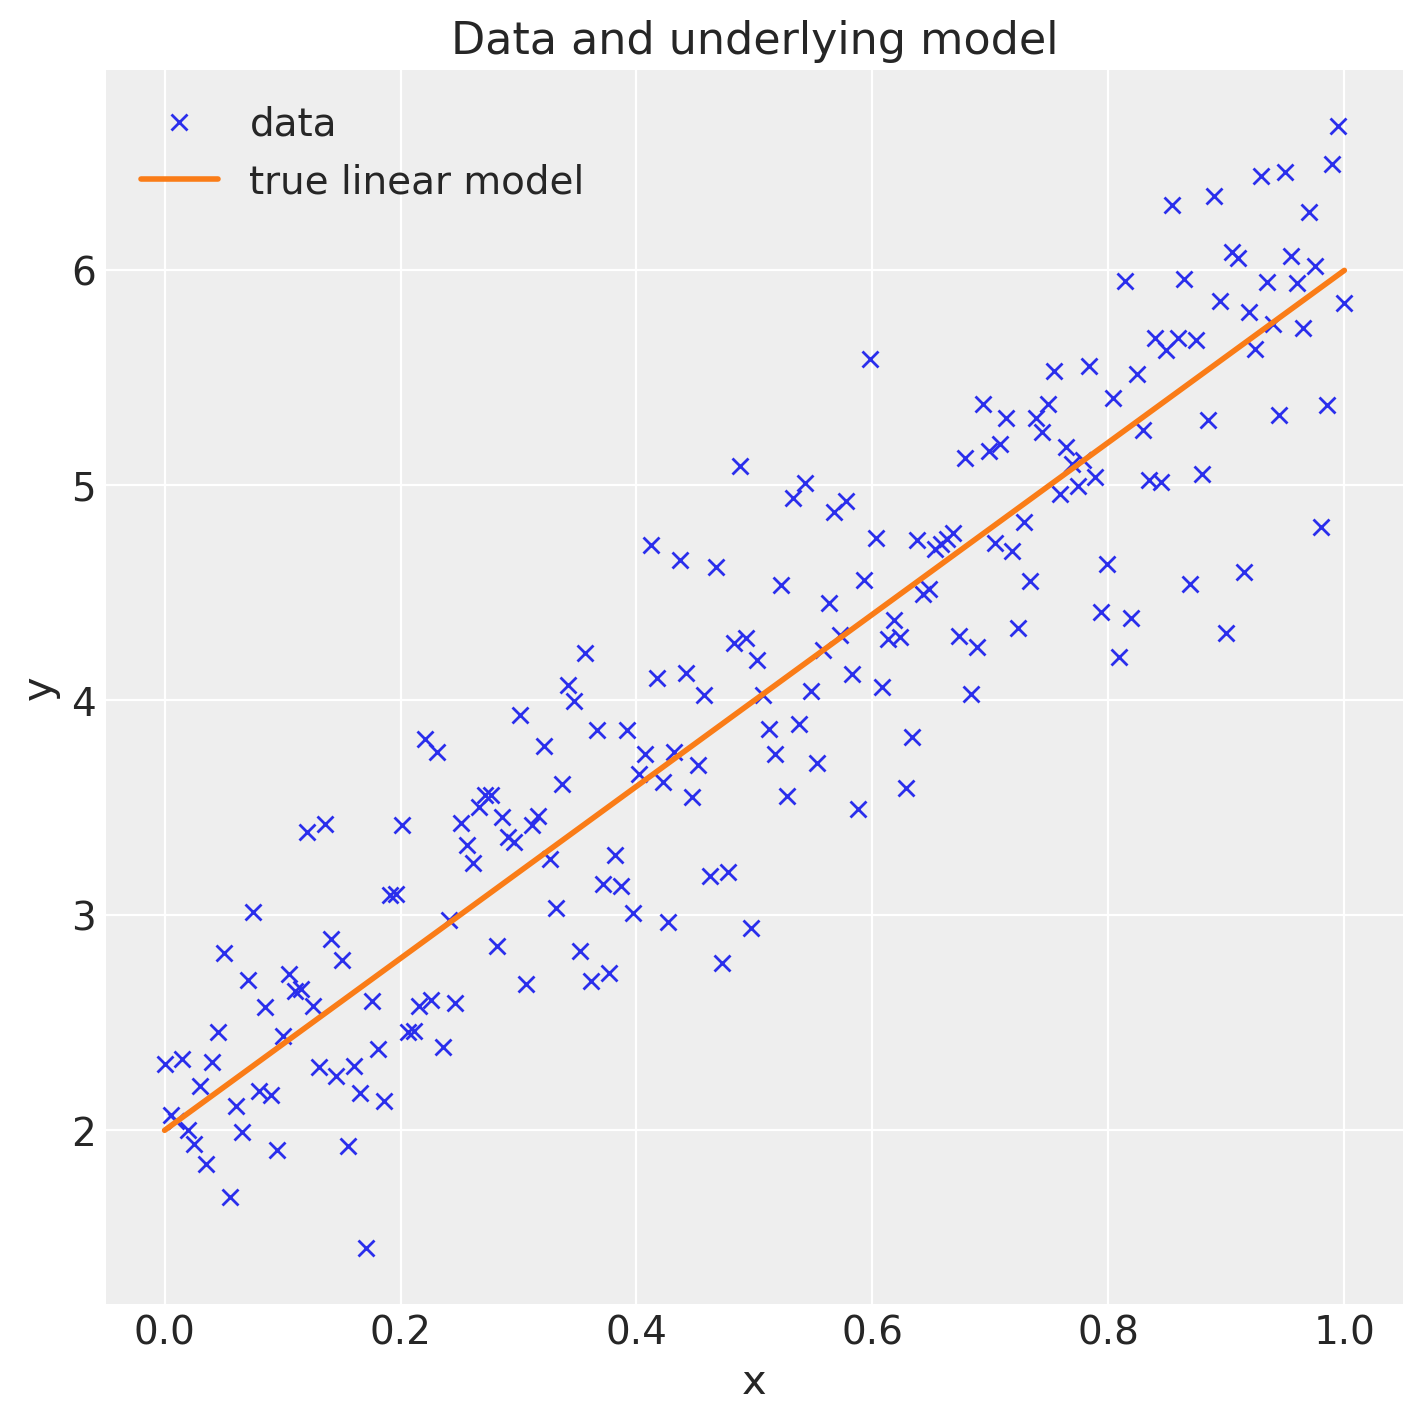

In [22]:
### Plot linear model w/ data
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Data and underlying model')
ax.plot(x, y, 'x', label='data');
ax.plot(x, y_true, label='true linear model', lw=2.);
plt.legend(loc=0);

<Figure size 700x700 with 0 Axes>

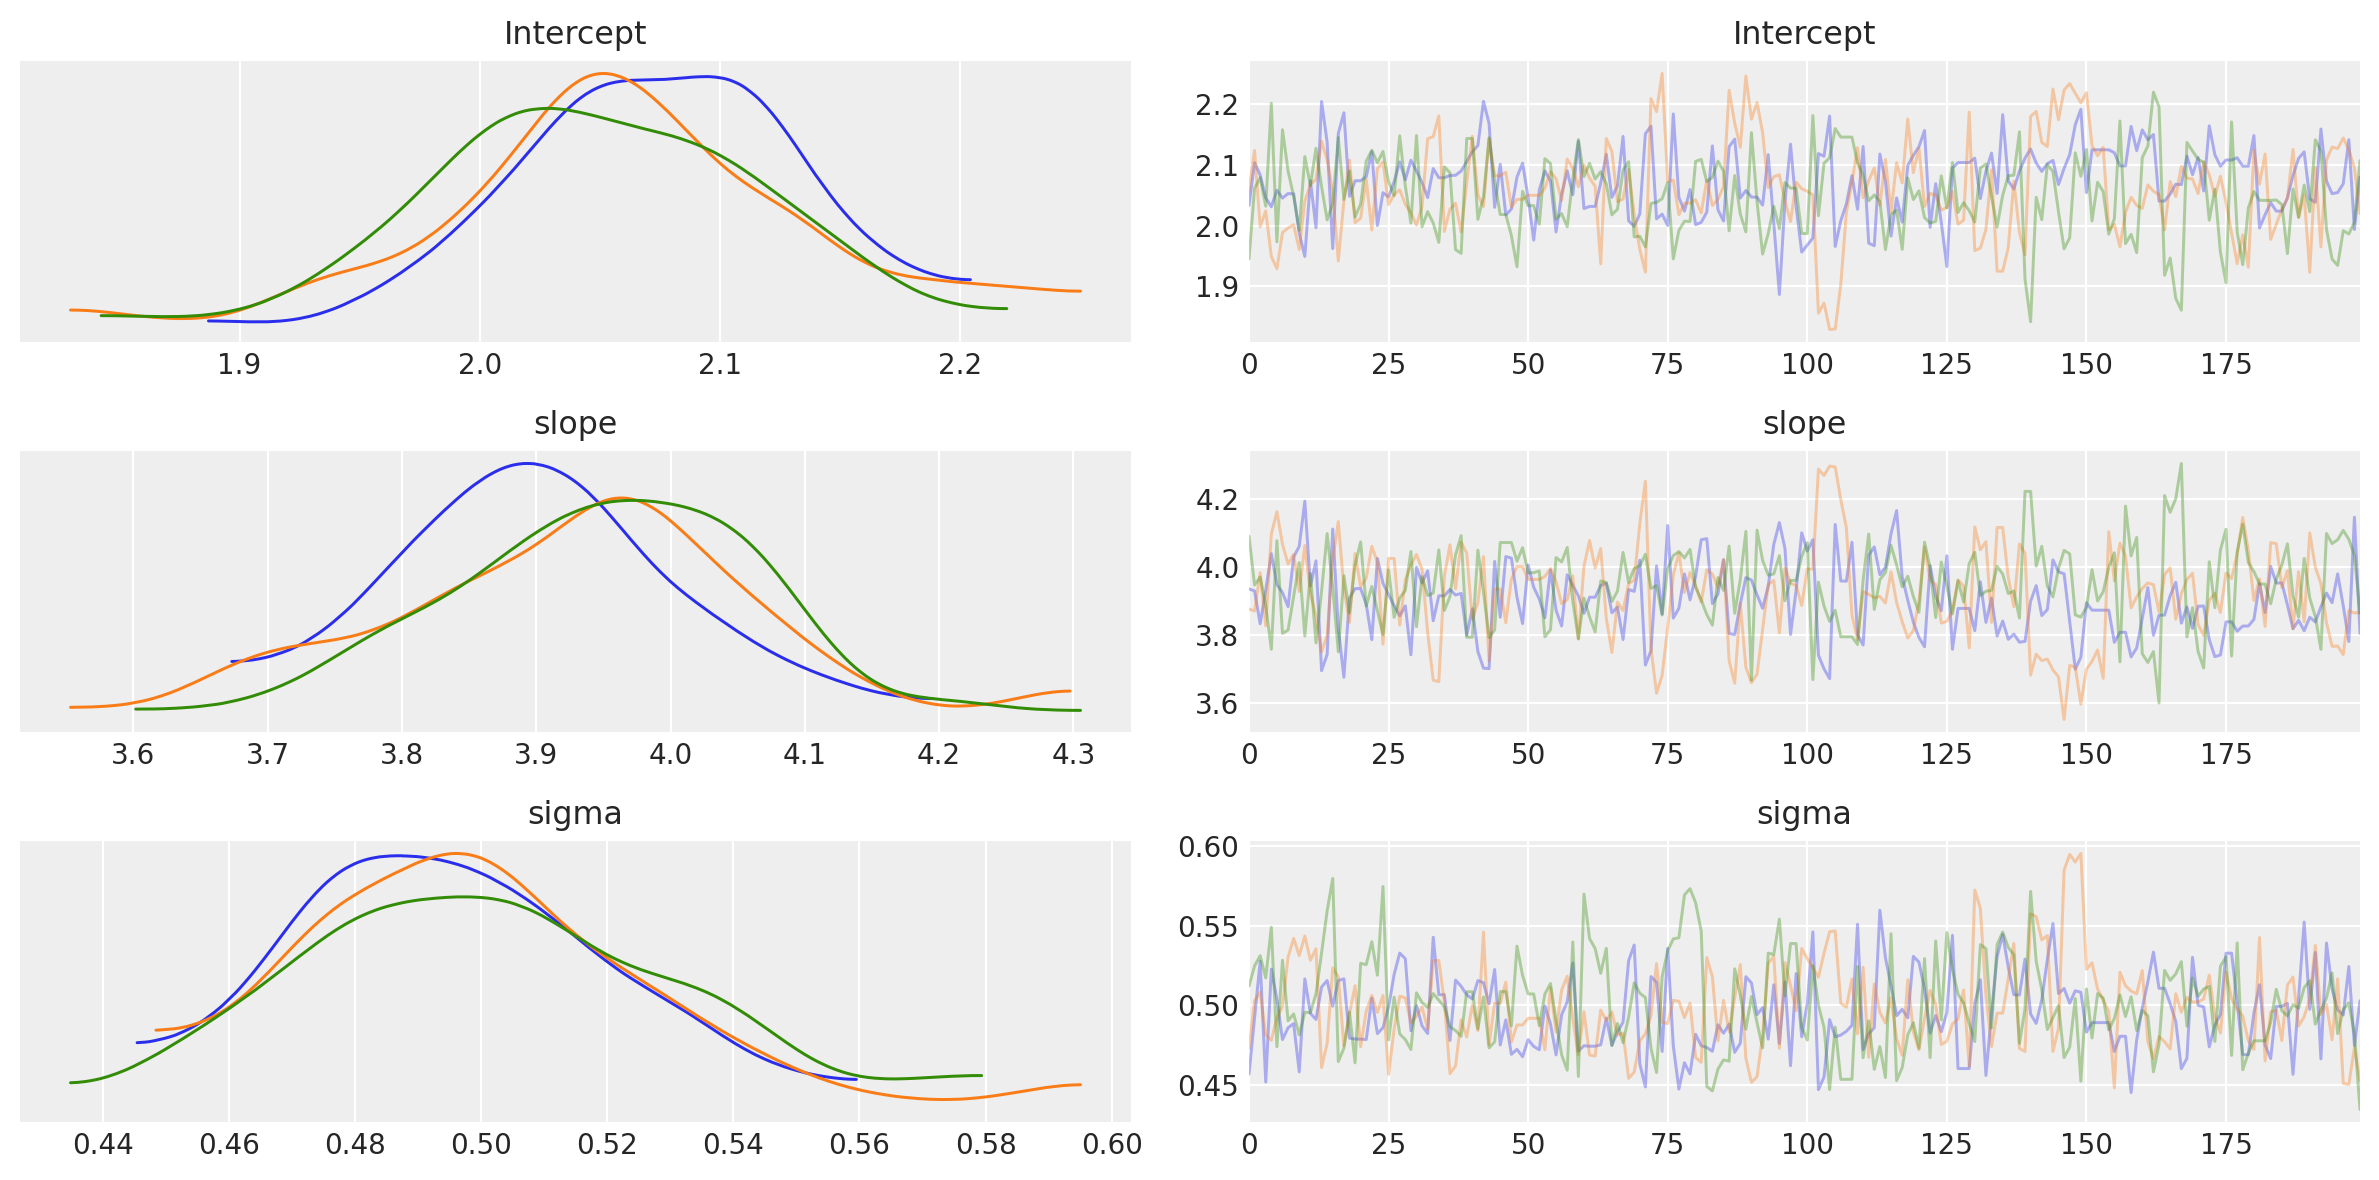

In [23]:
### Plot traces
plt.figure(figsize=(7, 7))
az.plot_trace(trace);
plt.tight_layout();

<Figure size 700x700 with 0 Axes>

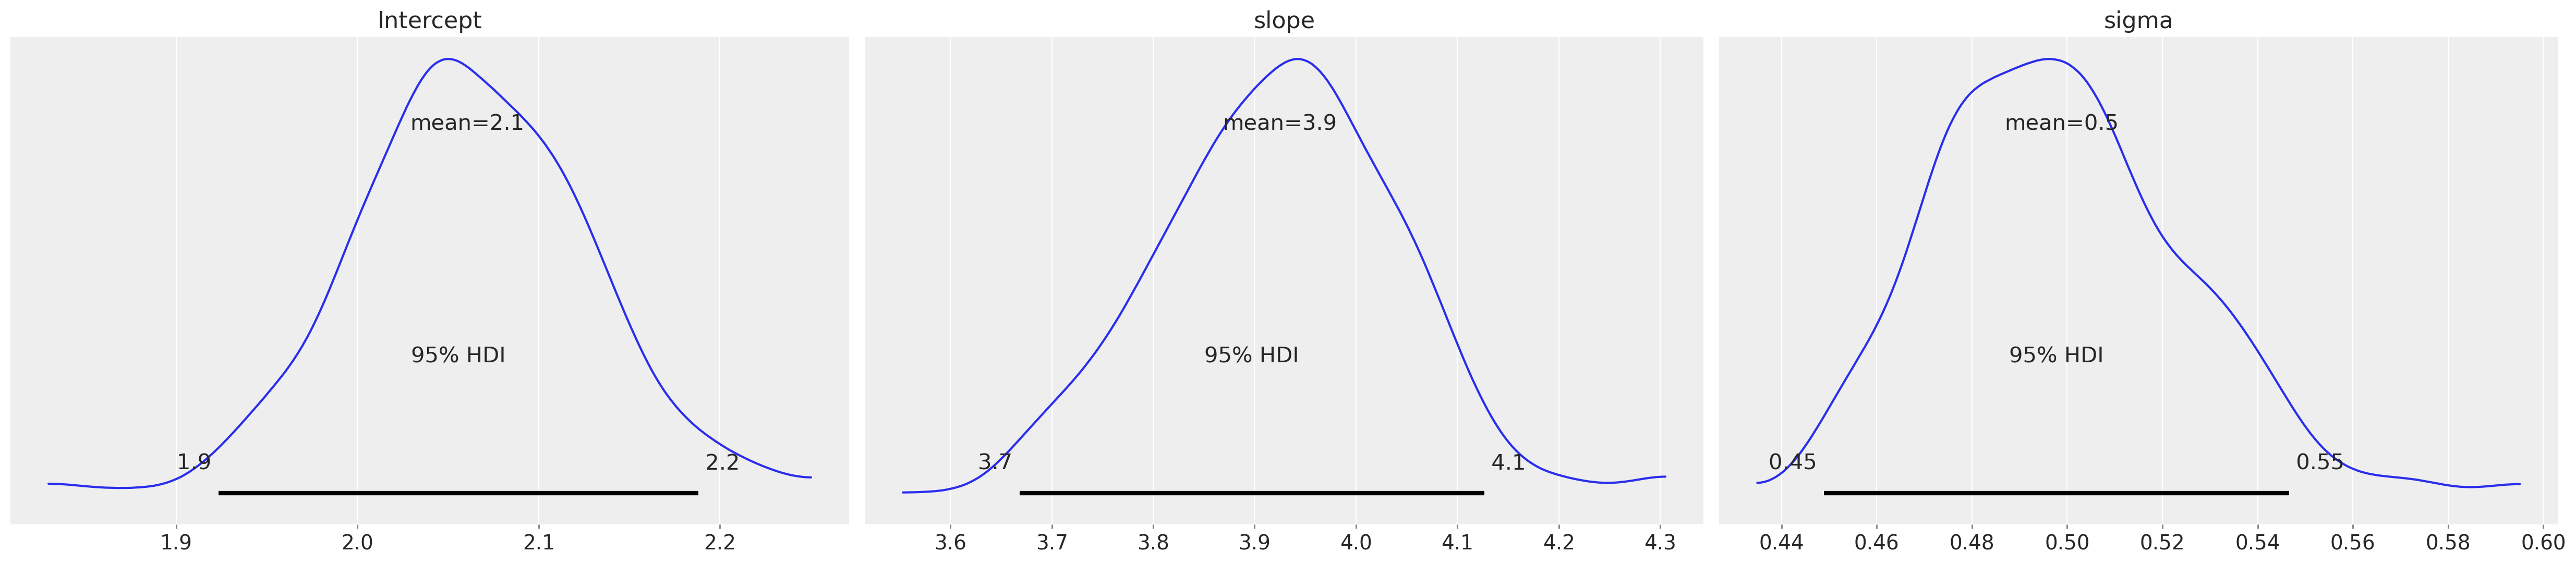

In [24]:
### Plot posterior w/ credible region
plt.figure(figsize=(7, 7))
az.plot_posterior(trace, hdi_prob=0.95);
plt.tight_layout();

In [14]:
### function to graph different models together for comparison

def graph_comparisons(traces, m_names, p_names=['sigma', 'Intercept', 'slope']):       
    for i in range(len(p_names)):
        plt.figure(figsize=(7, 7)) 
        ax = az.plot_forest(traces,  
                    kind='ridgeplot',
                    var_names=p_names[i],
                    model_names = m_names,
                    combined=True,
                    ridgeplot_overlap=5,
                    ridgeplot_truncate=False,
                    hdi_prob = 0.95,
                    ridgeplot_quantiles = [.25,.5,.75],
                    colors=['blue', 'red', 'green'])        
        plt.tight_layout();
        ax[0].set_title('Comparing posterior distributions')

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [slope, Intercept, sigma]
Sampling chain 0, 0 divergences: 100%|██████████| 2200/2200 [00:01<00:00, 1154.96it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [slope, Intercept, sigma]
Sampling chain 0, 0 divergences: 100%|██████████| 2200/2200 [00:01<00:00, 1139.59it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [slope, Intercept, sigma]
Sampling chain 0, 0 divergences: 100%|██████████| 2200/2200 [00:01<00:00, 1158.63it/s]
Only one chain was sampled, this makes it impo

<Figure size 700x700 with 0 Axes>

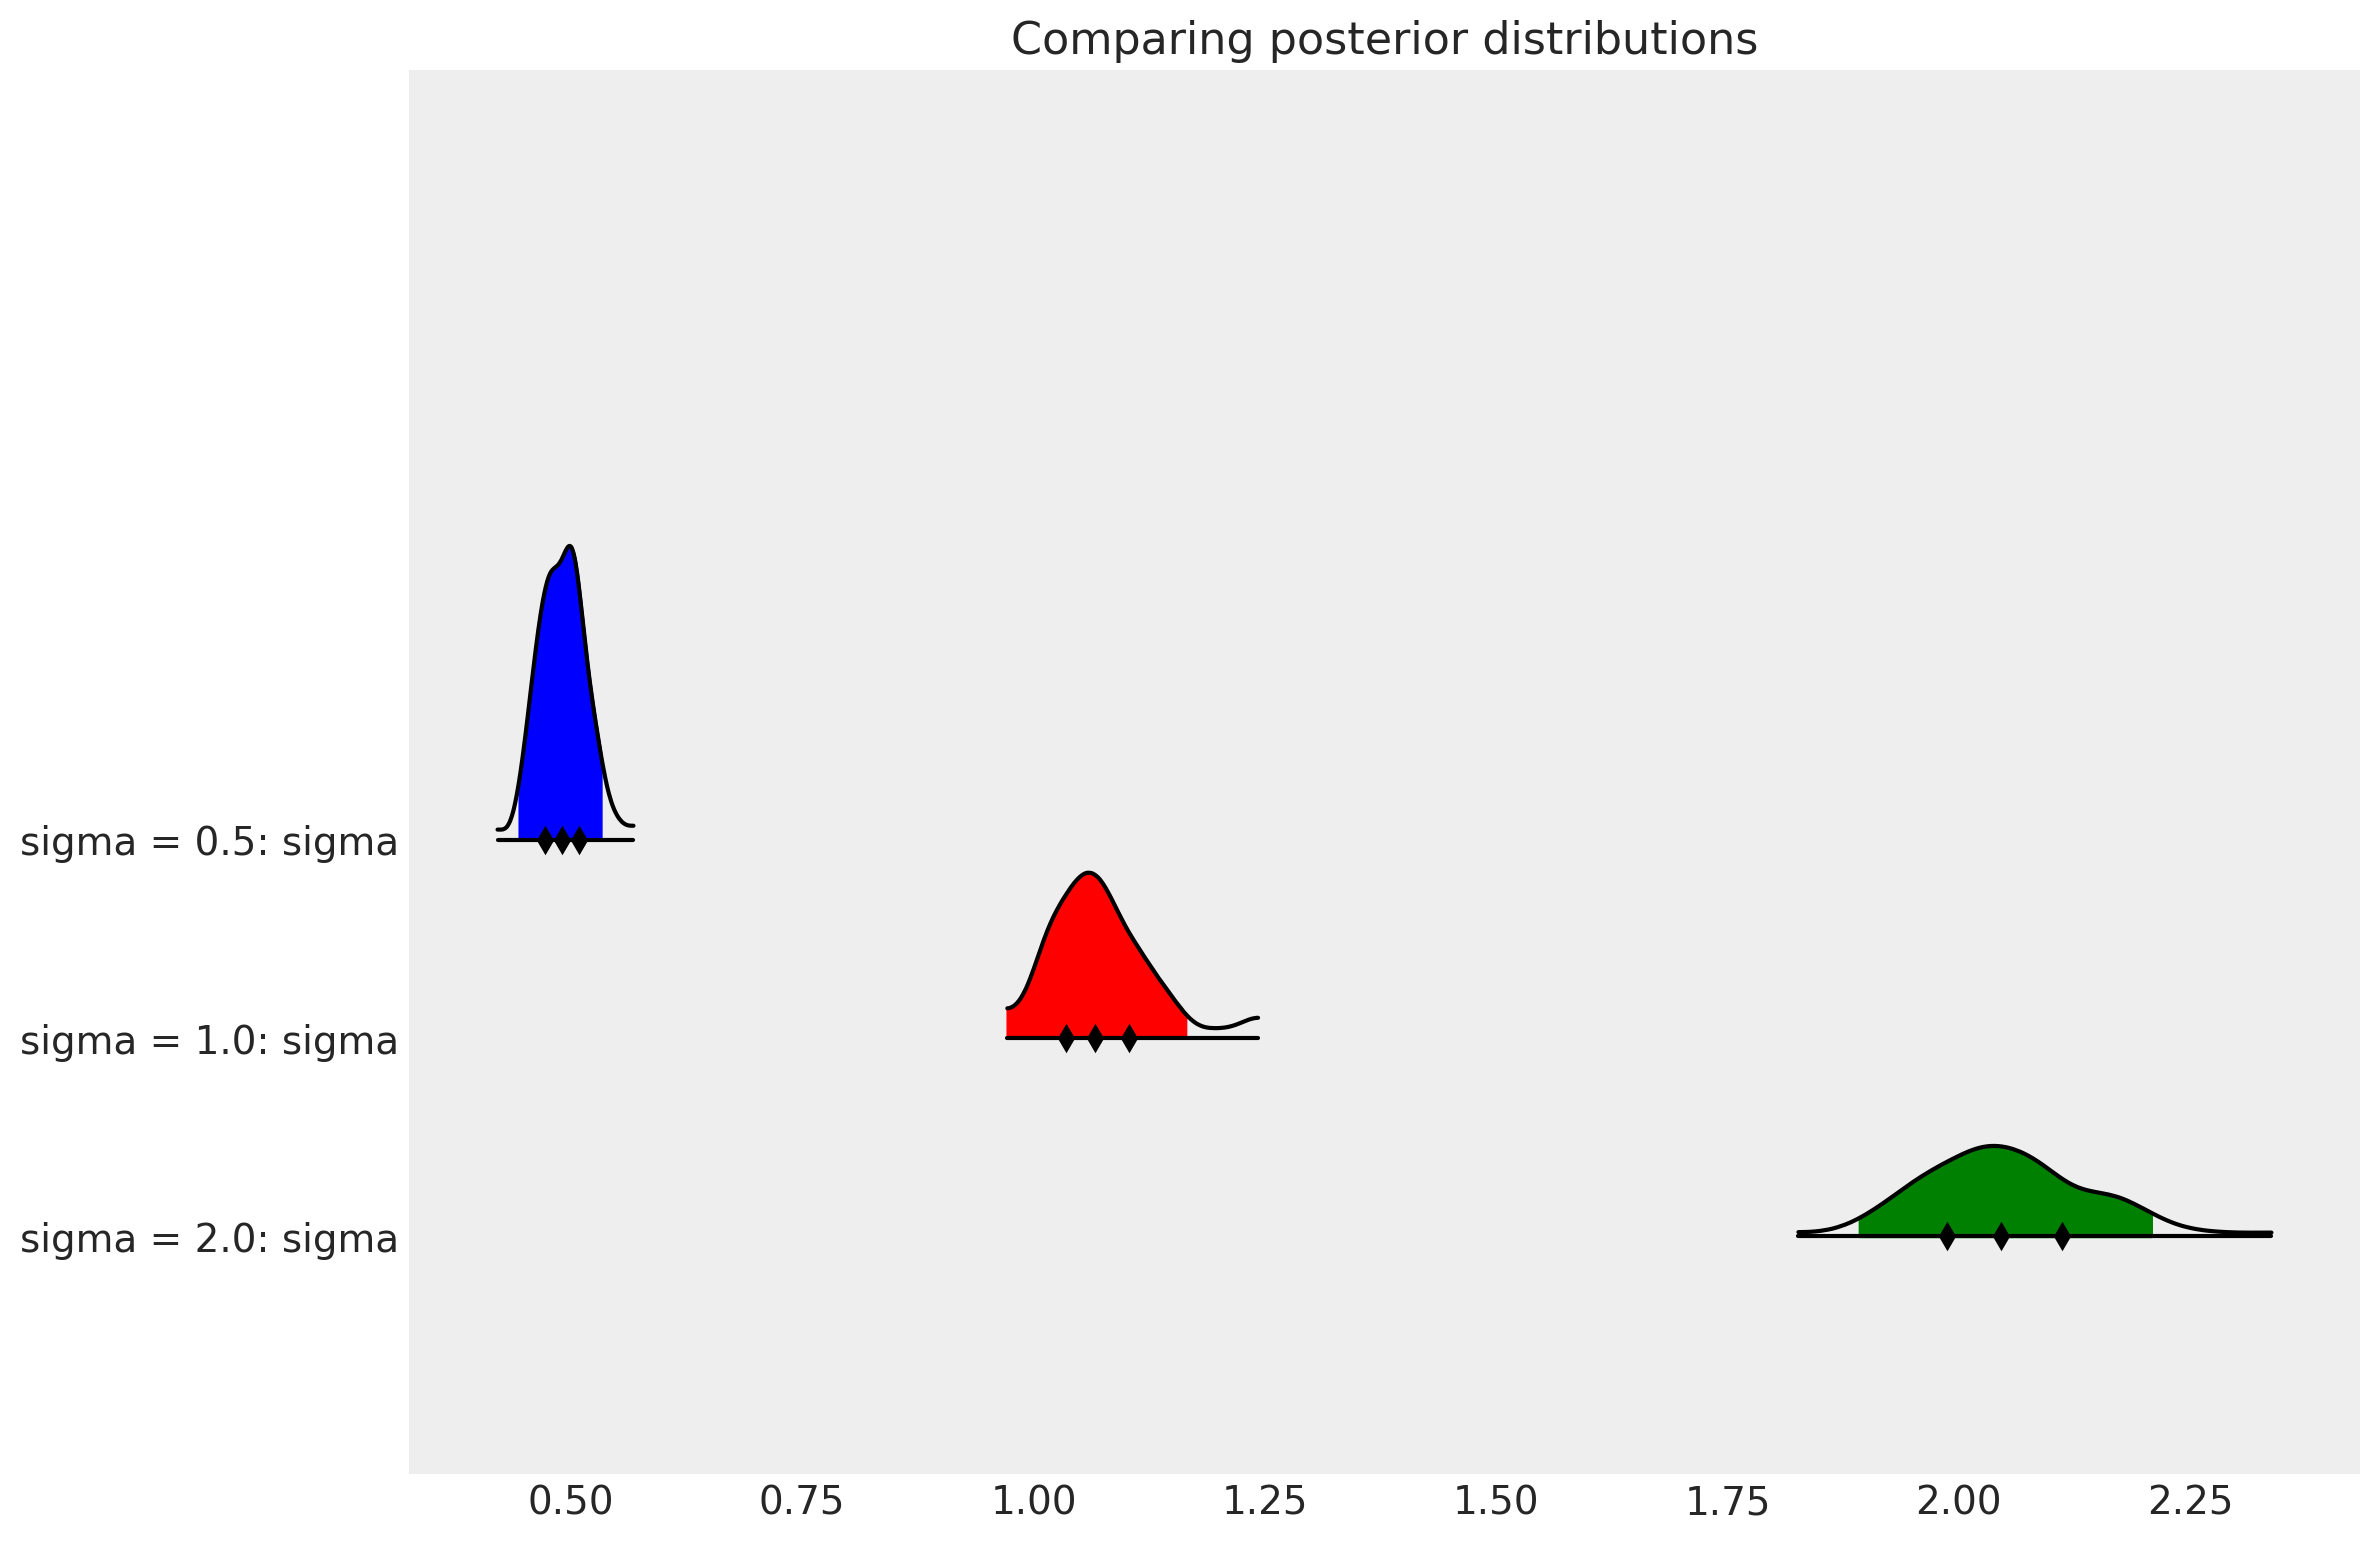

<Figure size 700x700 with 0 Axes>

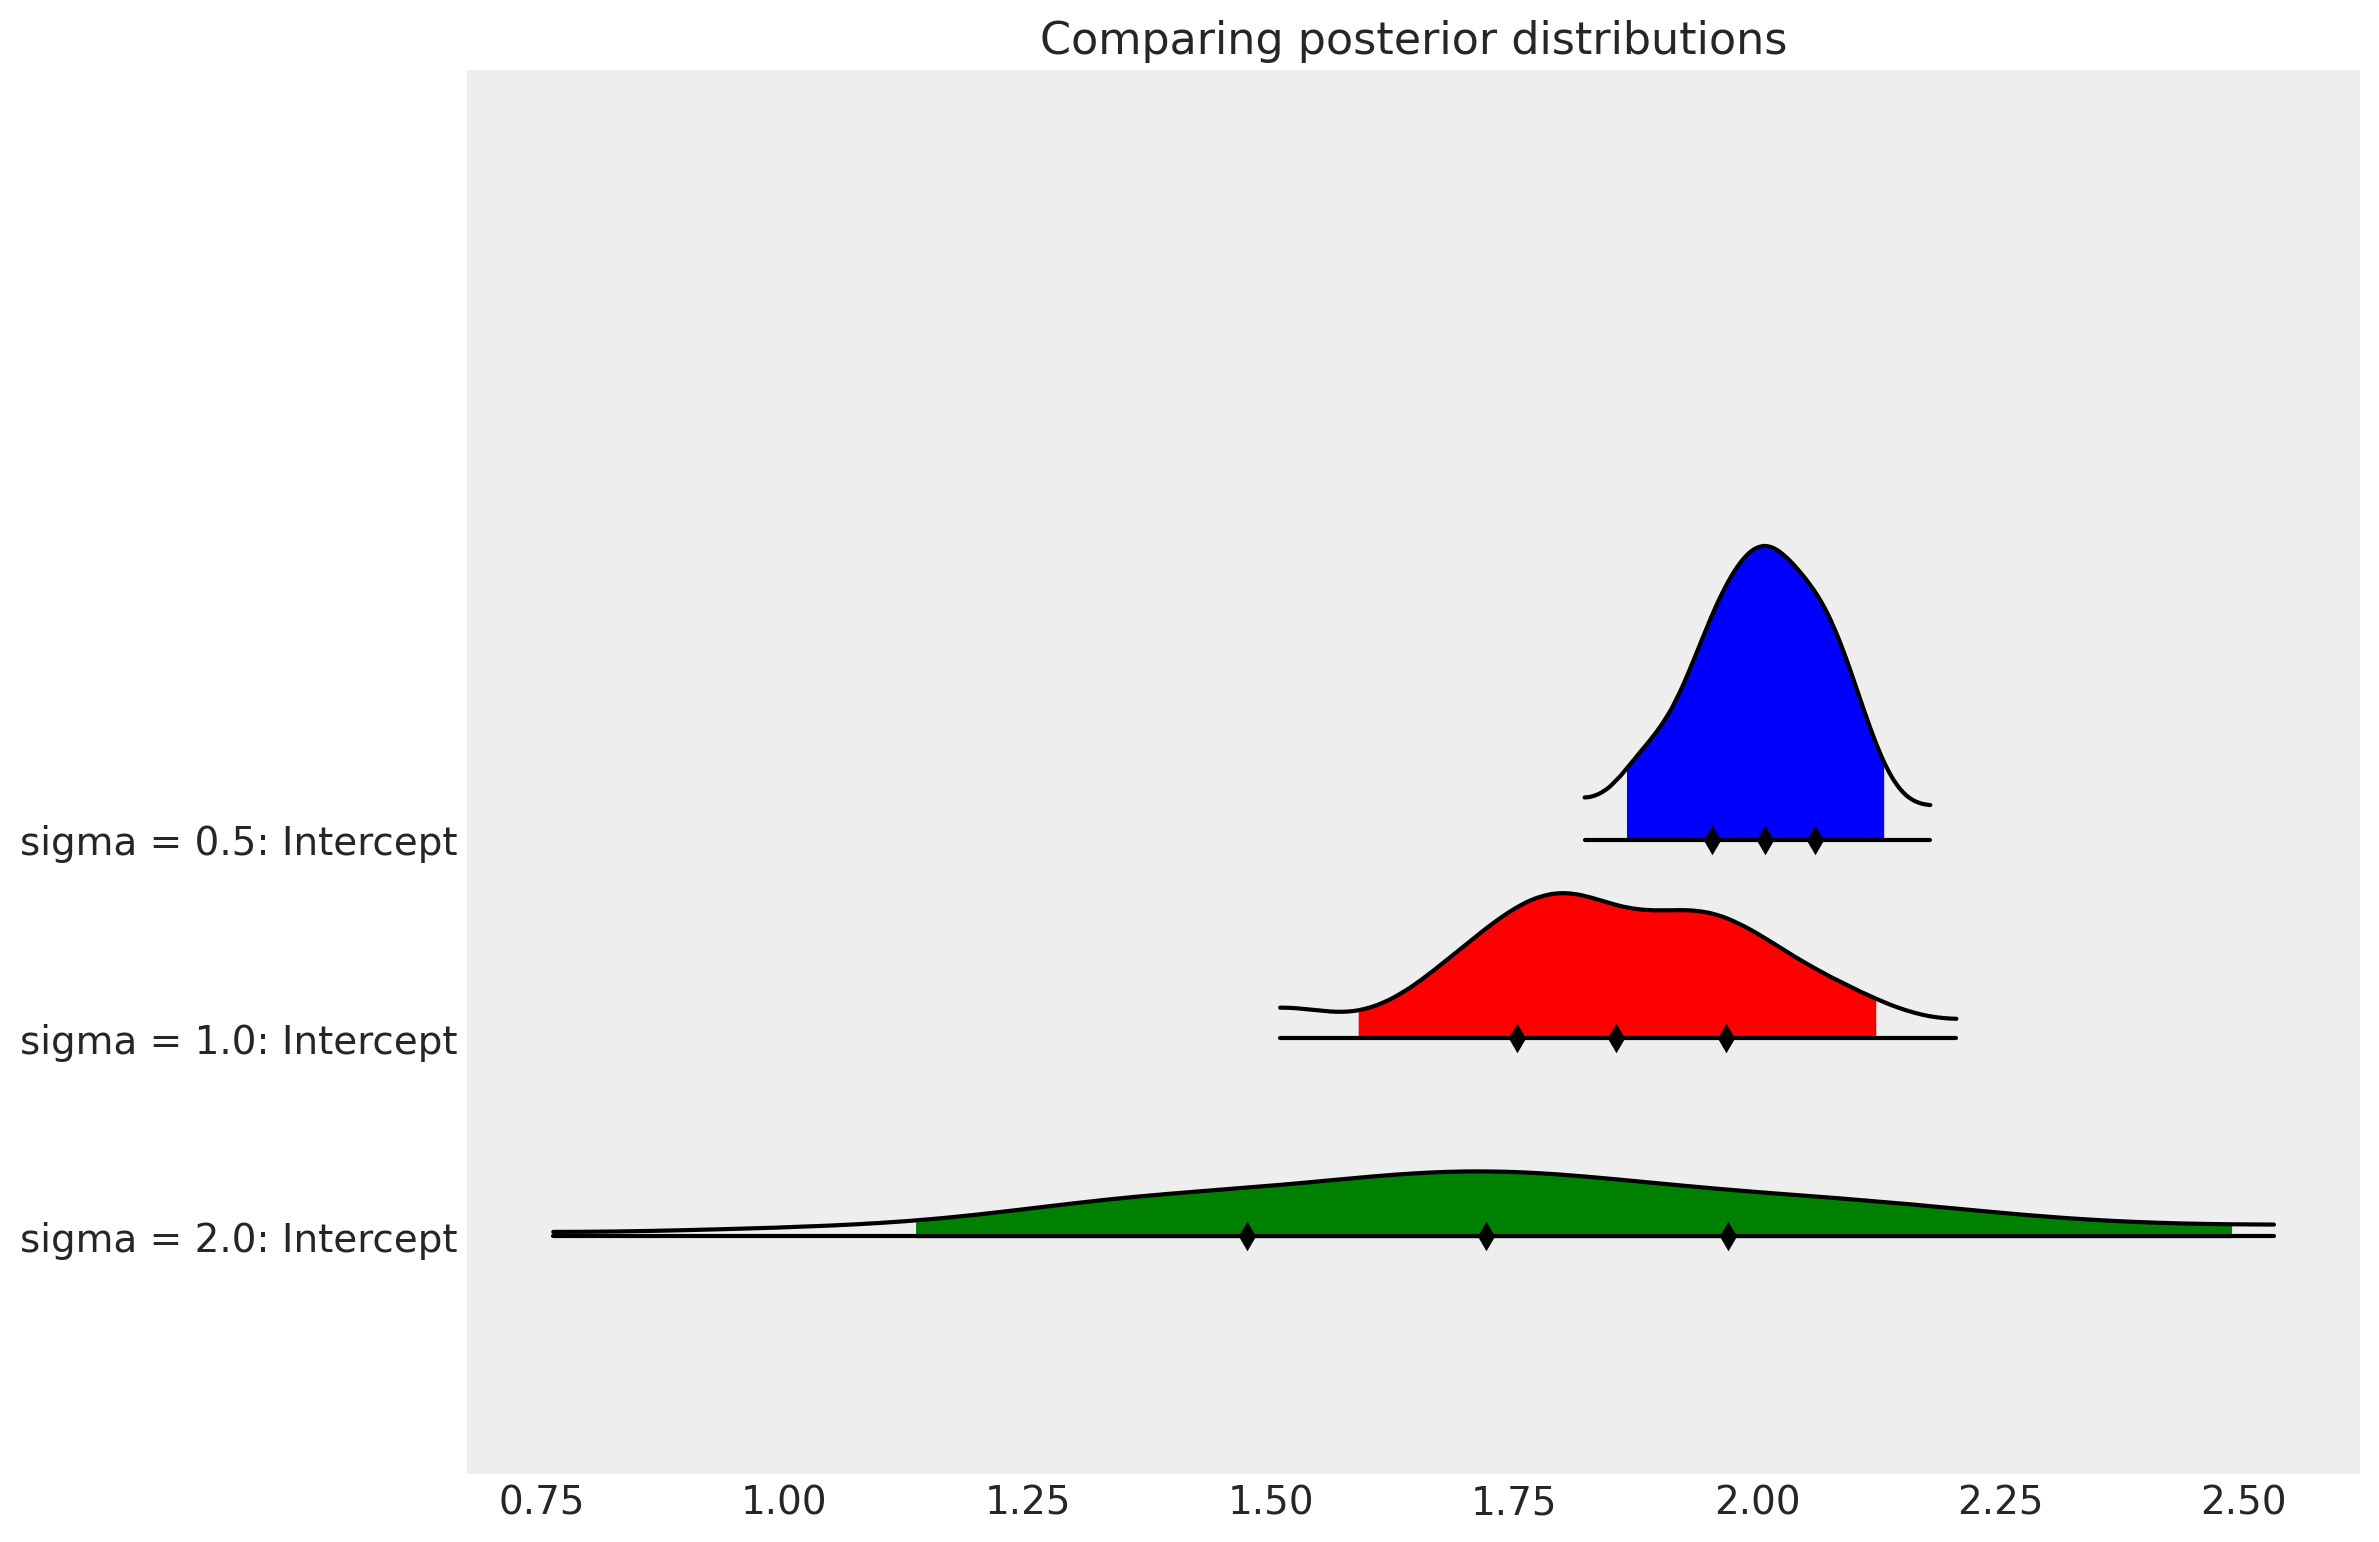

<Figure size 700x700 with 0 Axes>

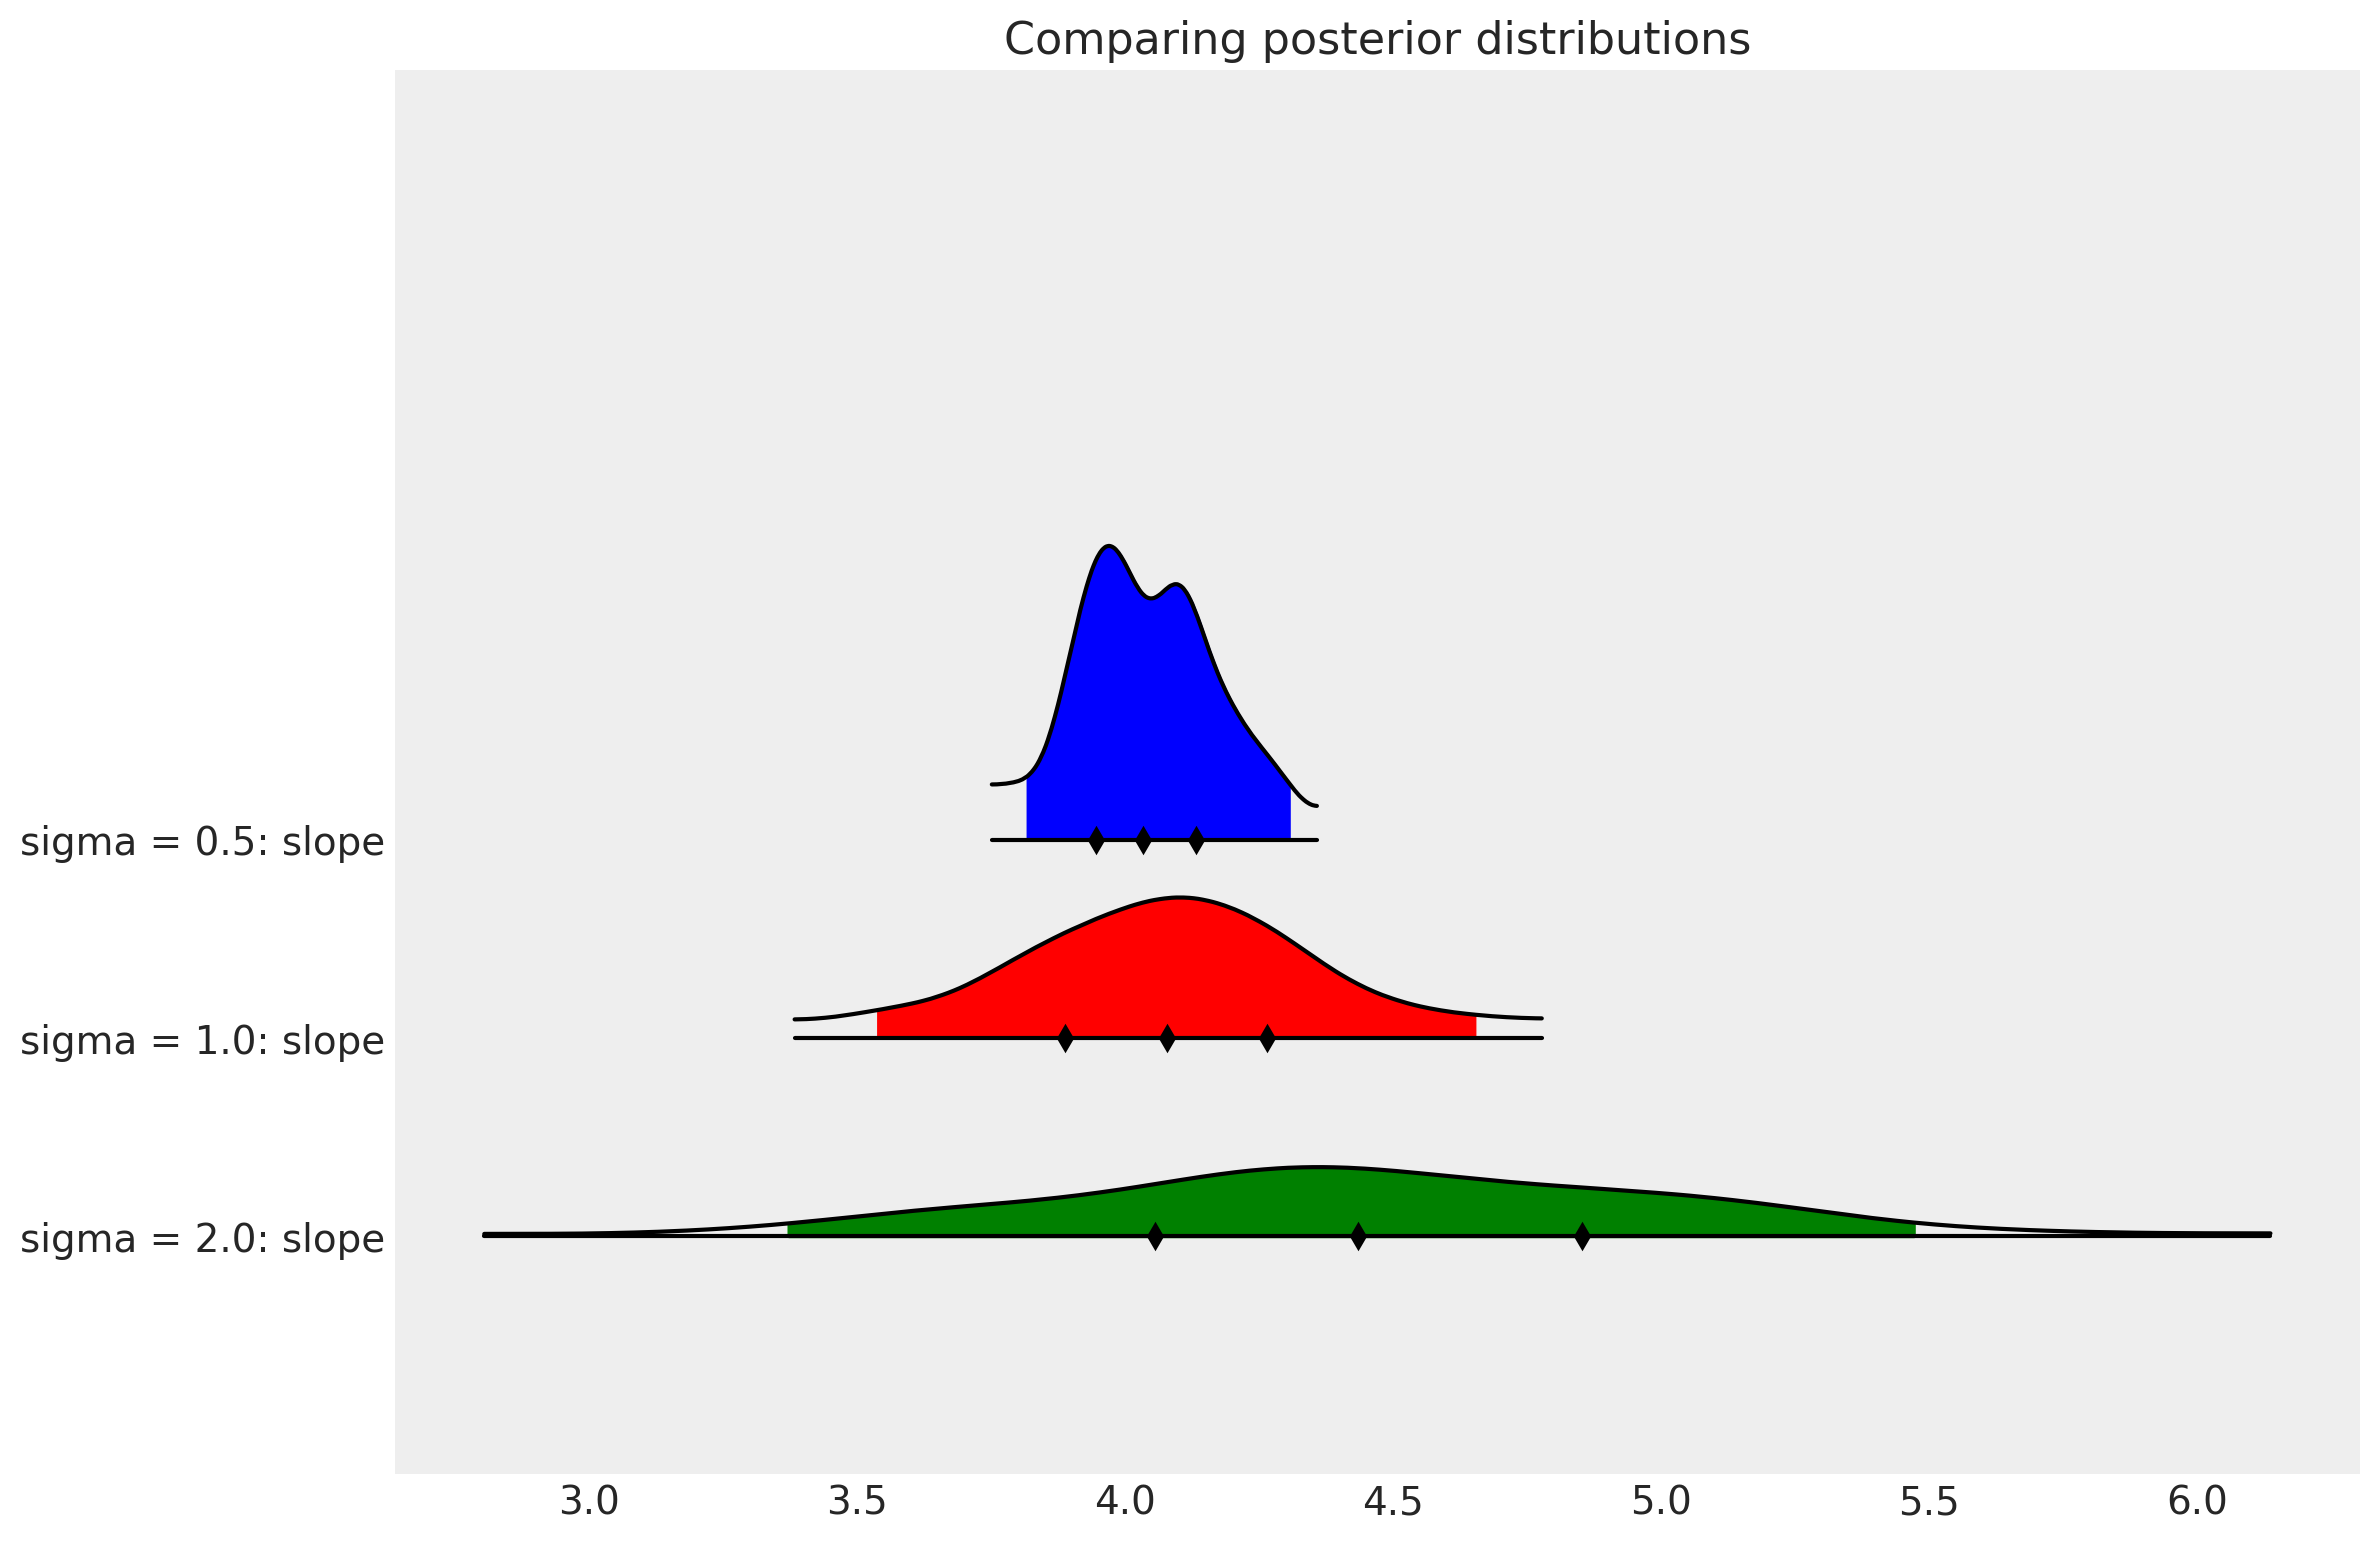

In [15]:
### more examples - comparing posteriors for different sigma values

sigmas = [0.5, 1, 2]
m_names = ['sigma = 0.5', 'sigma = 1.0', 'sigma = 2.0']
traces = []

for i in range(len(sigmas)):
    x,y,y_true = generate_data(sigma=sigmas[i])
    trace = sampler(x,y, chains = 1)
    traces.append(trace)
   
graph_comparisons(traces,m_names)    

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [slope, Intercept, sigma]
Sampling chain 0, 0 divergences: 100%|██████████| 2200/2200 [00:02<00:00, 855.81it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [slope, Intercept, sigma]
Sampling chain 0, 0 divergences: 100%|██████████| 2200/2200 [00:02<00:00, 1040.63it/s]
The acceptance probability does not match the target. It is 0.8816940537138698, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [slope, 

<Figure size 700x700 with 0 Axes>

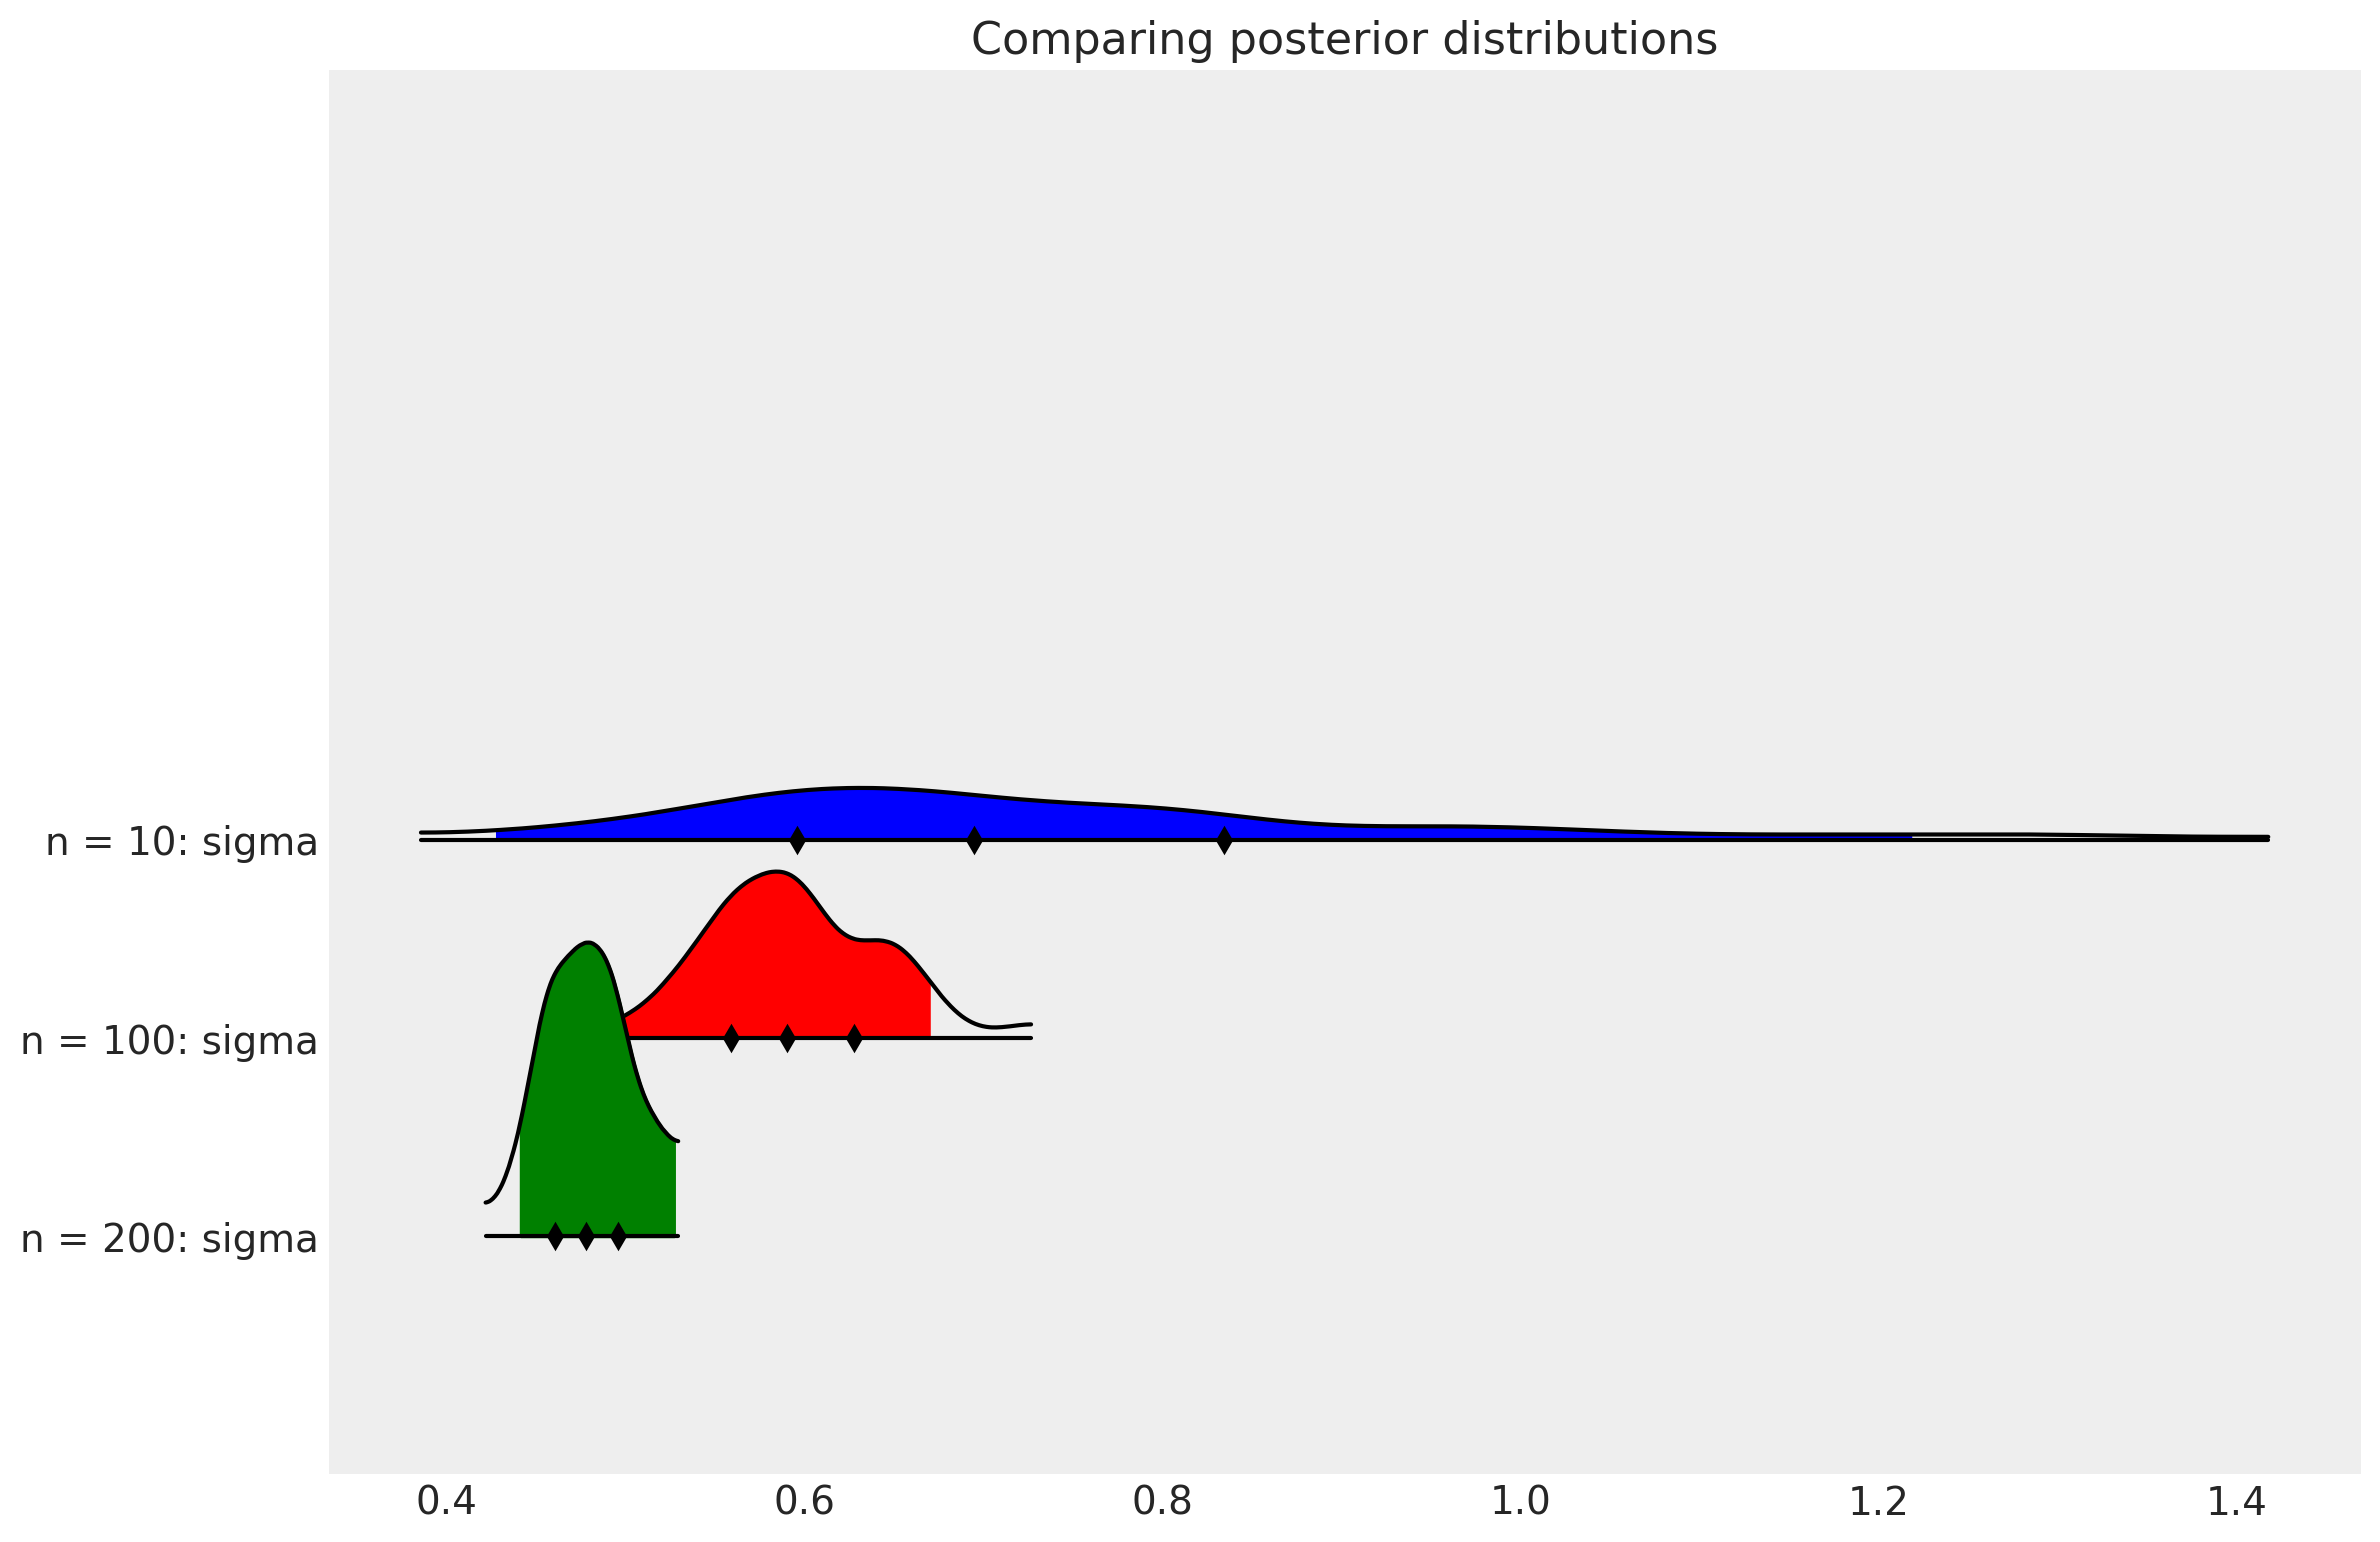

<Figure size 700x700 with 0 Axes>

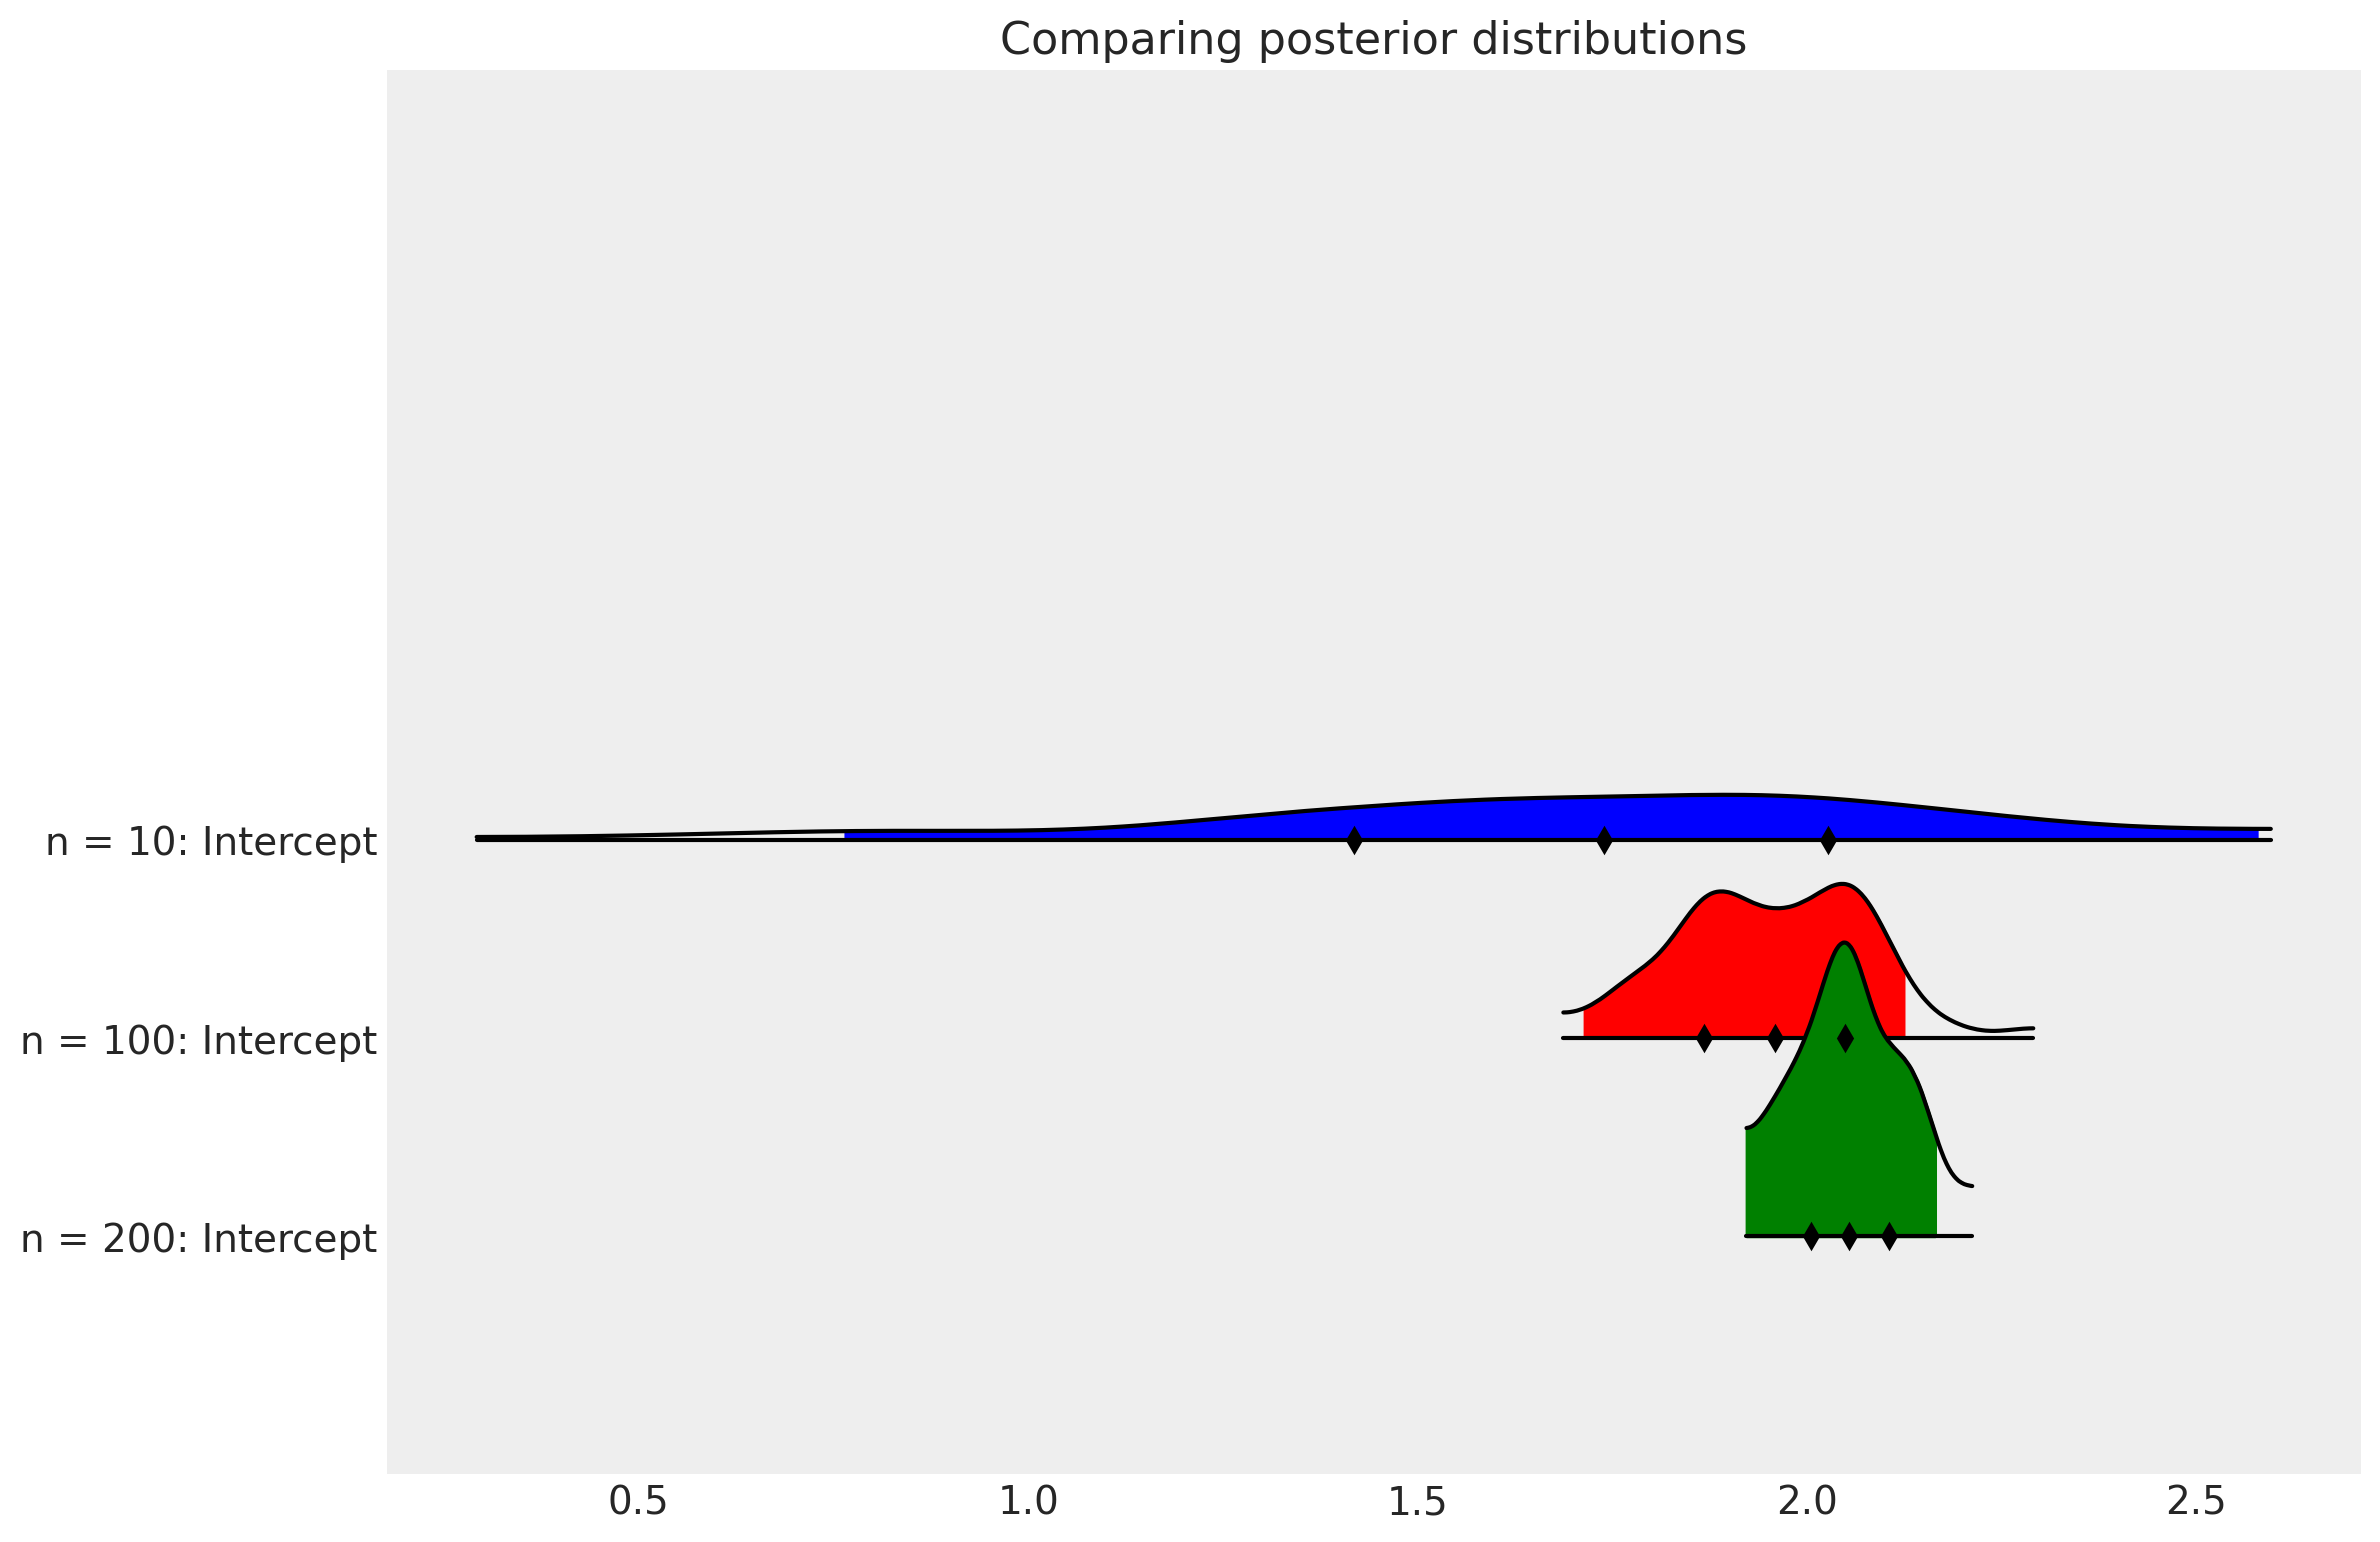

<Figure size 700x700 with 0 Axes>

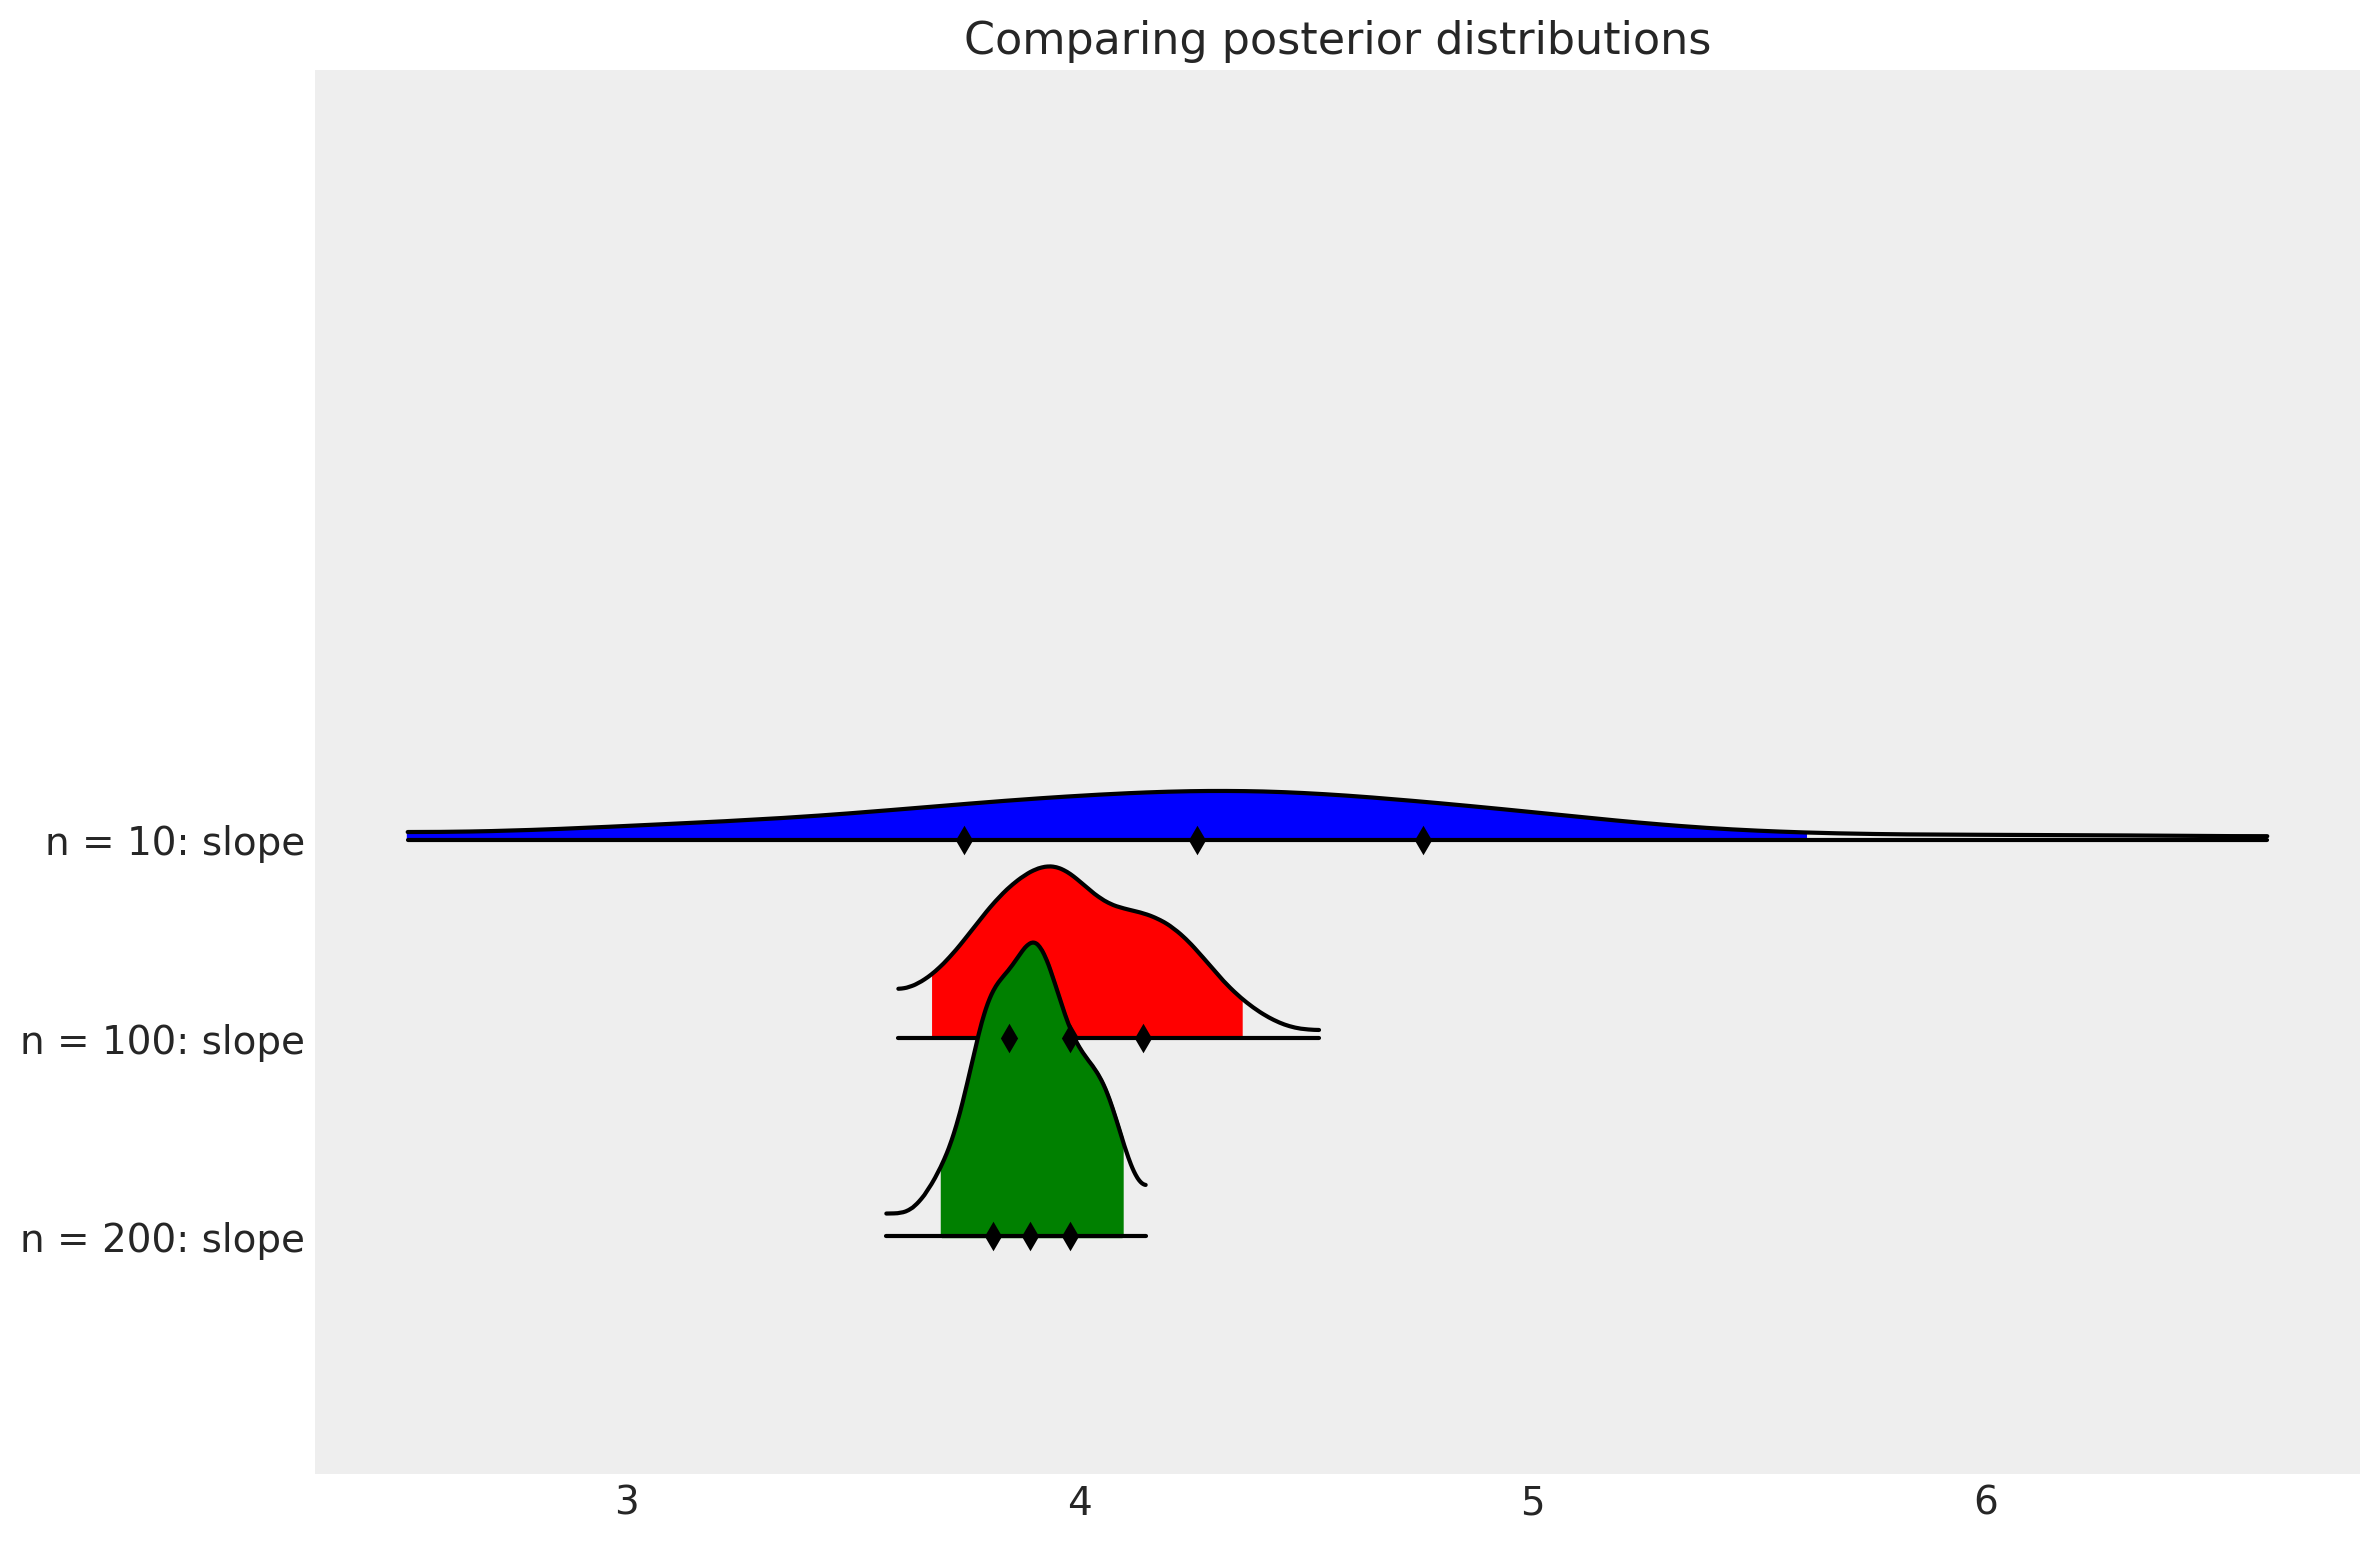

In [16]:
### more examples - comparing posteriors for different data sizes

data_size = [10, 100, 200]
m_names = ['n = 10', 'n = 100', 'n = 200']
traces = []

for i in range(len(data_size)):
    x,y,y_true = generate_data(data_size=data_size[i])
    trace = sampler(x,y, chains = 1)
    traces.append(trace)
   
graph_comparisons(traces,m_names)   



Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [slope, Intercept, sigma]
Sampling chain 0, 0 divergences: 100%|██████████| 2200/2200 [00:02<00:00, 992.06it/s] 
The acceptance probability does not match the target. It is 0.6299551638575075, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [slope, Intercept, sigma]
Sampling chain 0, 0 divergences: 100%|██████████| 2200/2200 [00:02<00:00, 892.53it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


<Figure size 700x700 with 0 Axes>

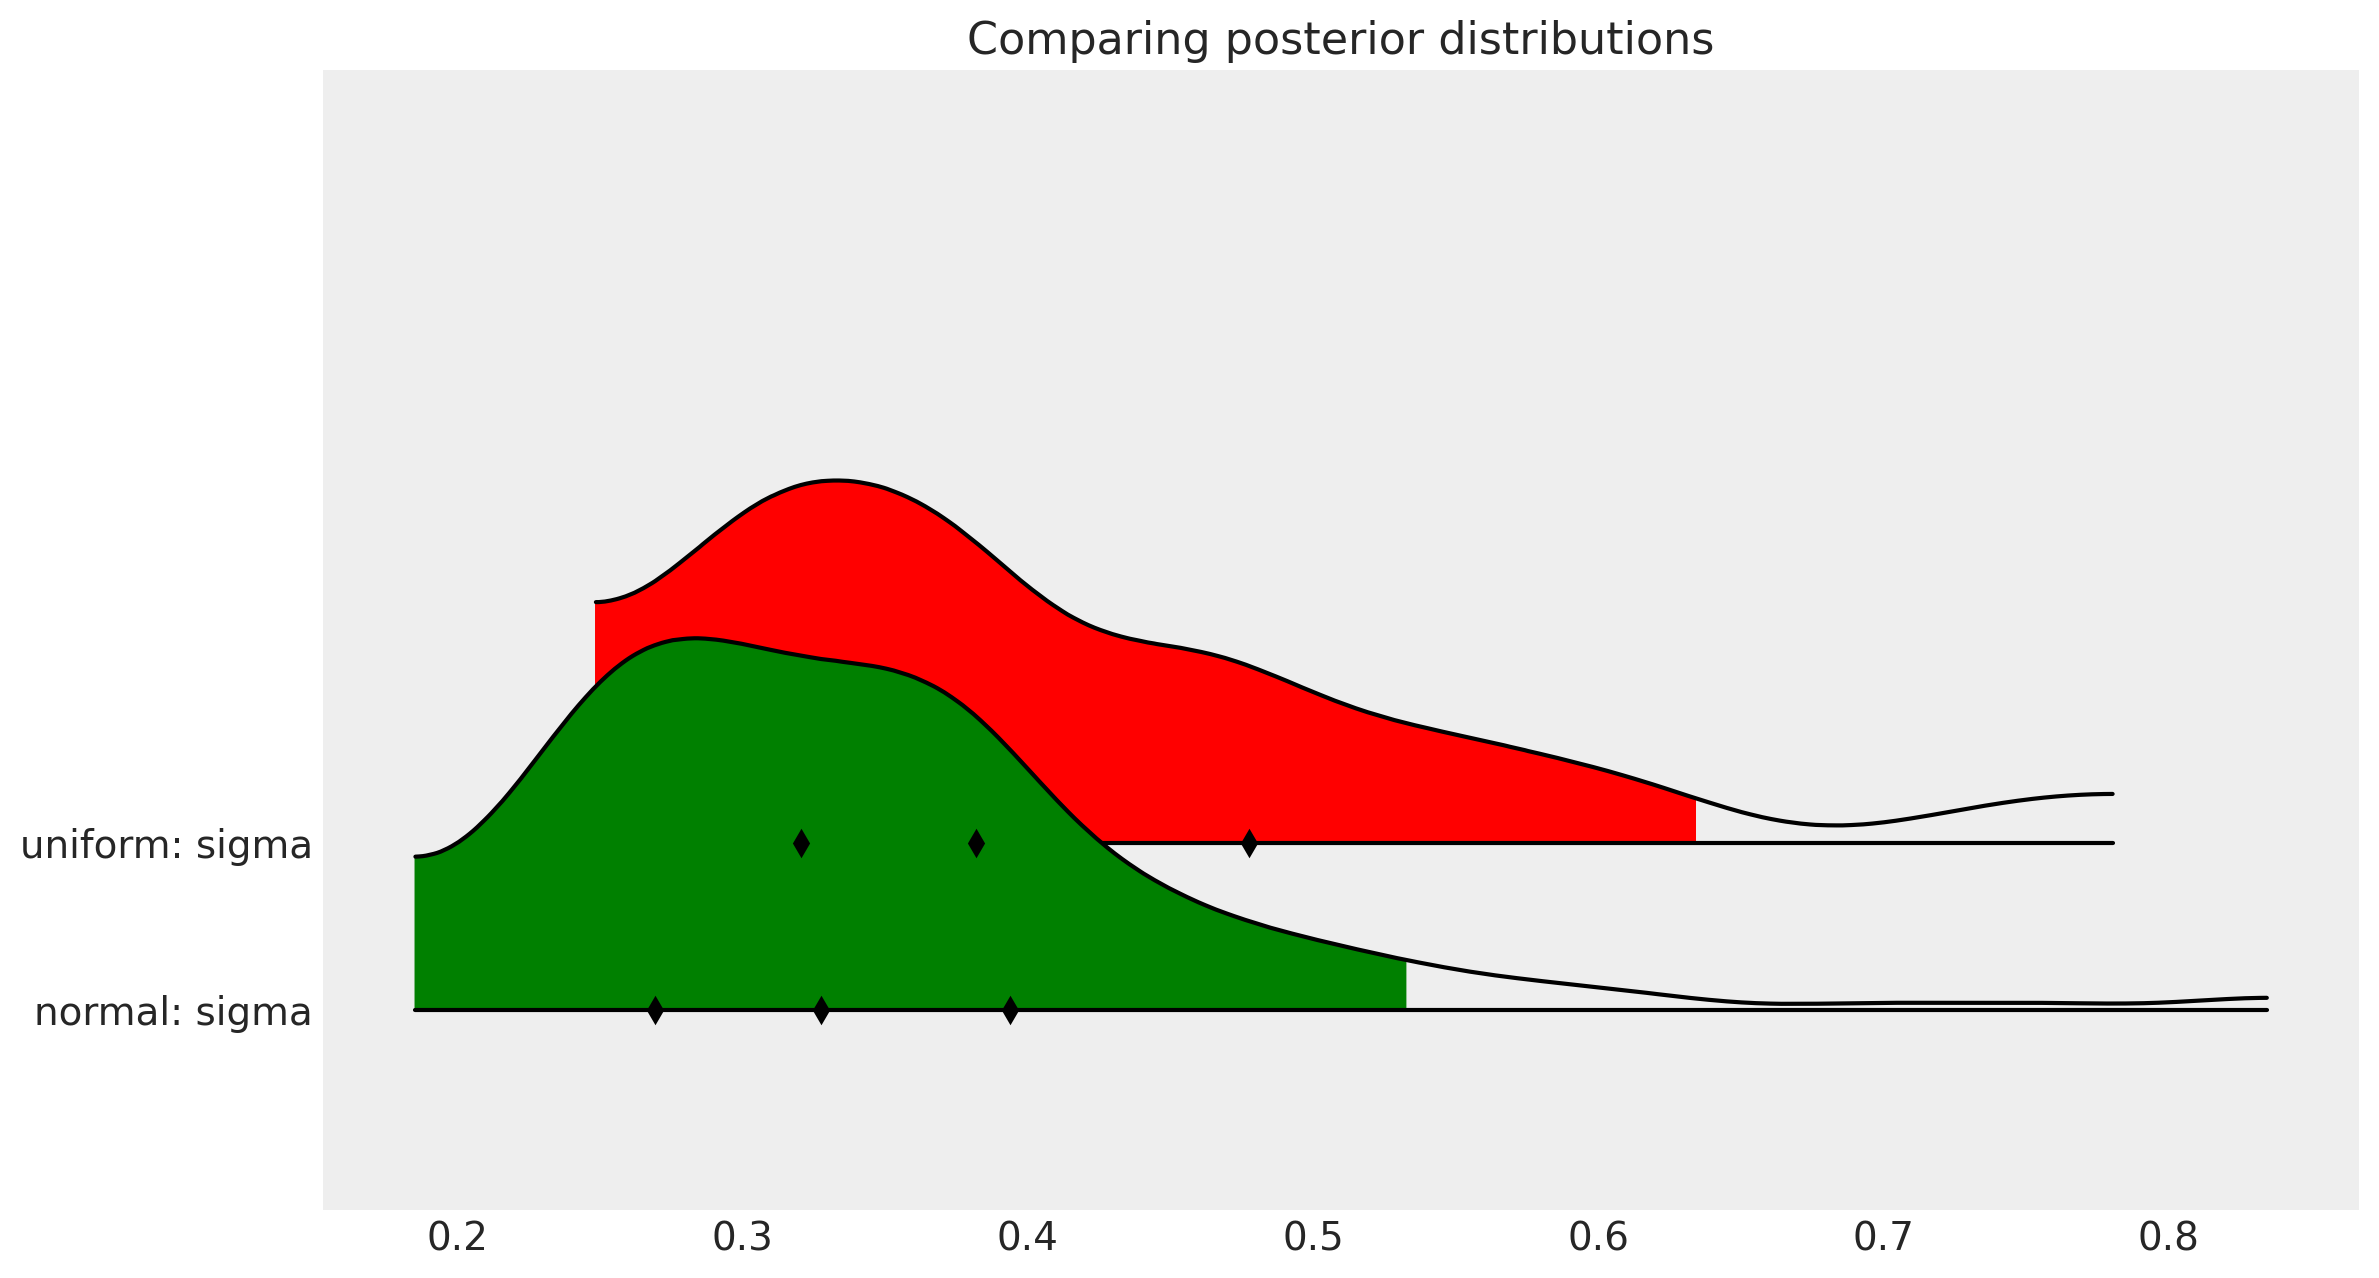

<Figure size 700x700 with 0 Axes>

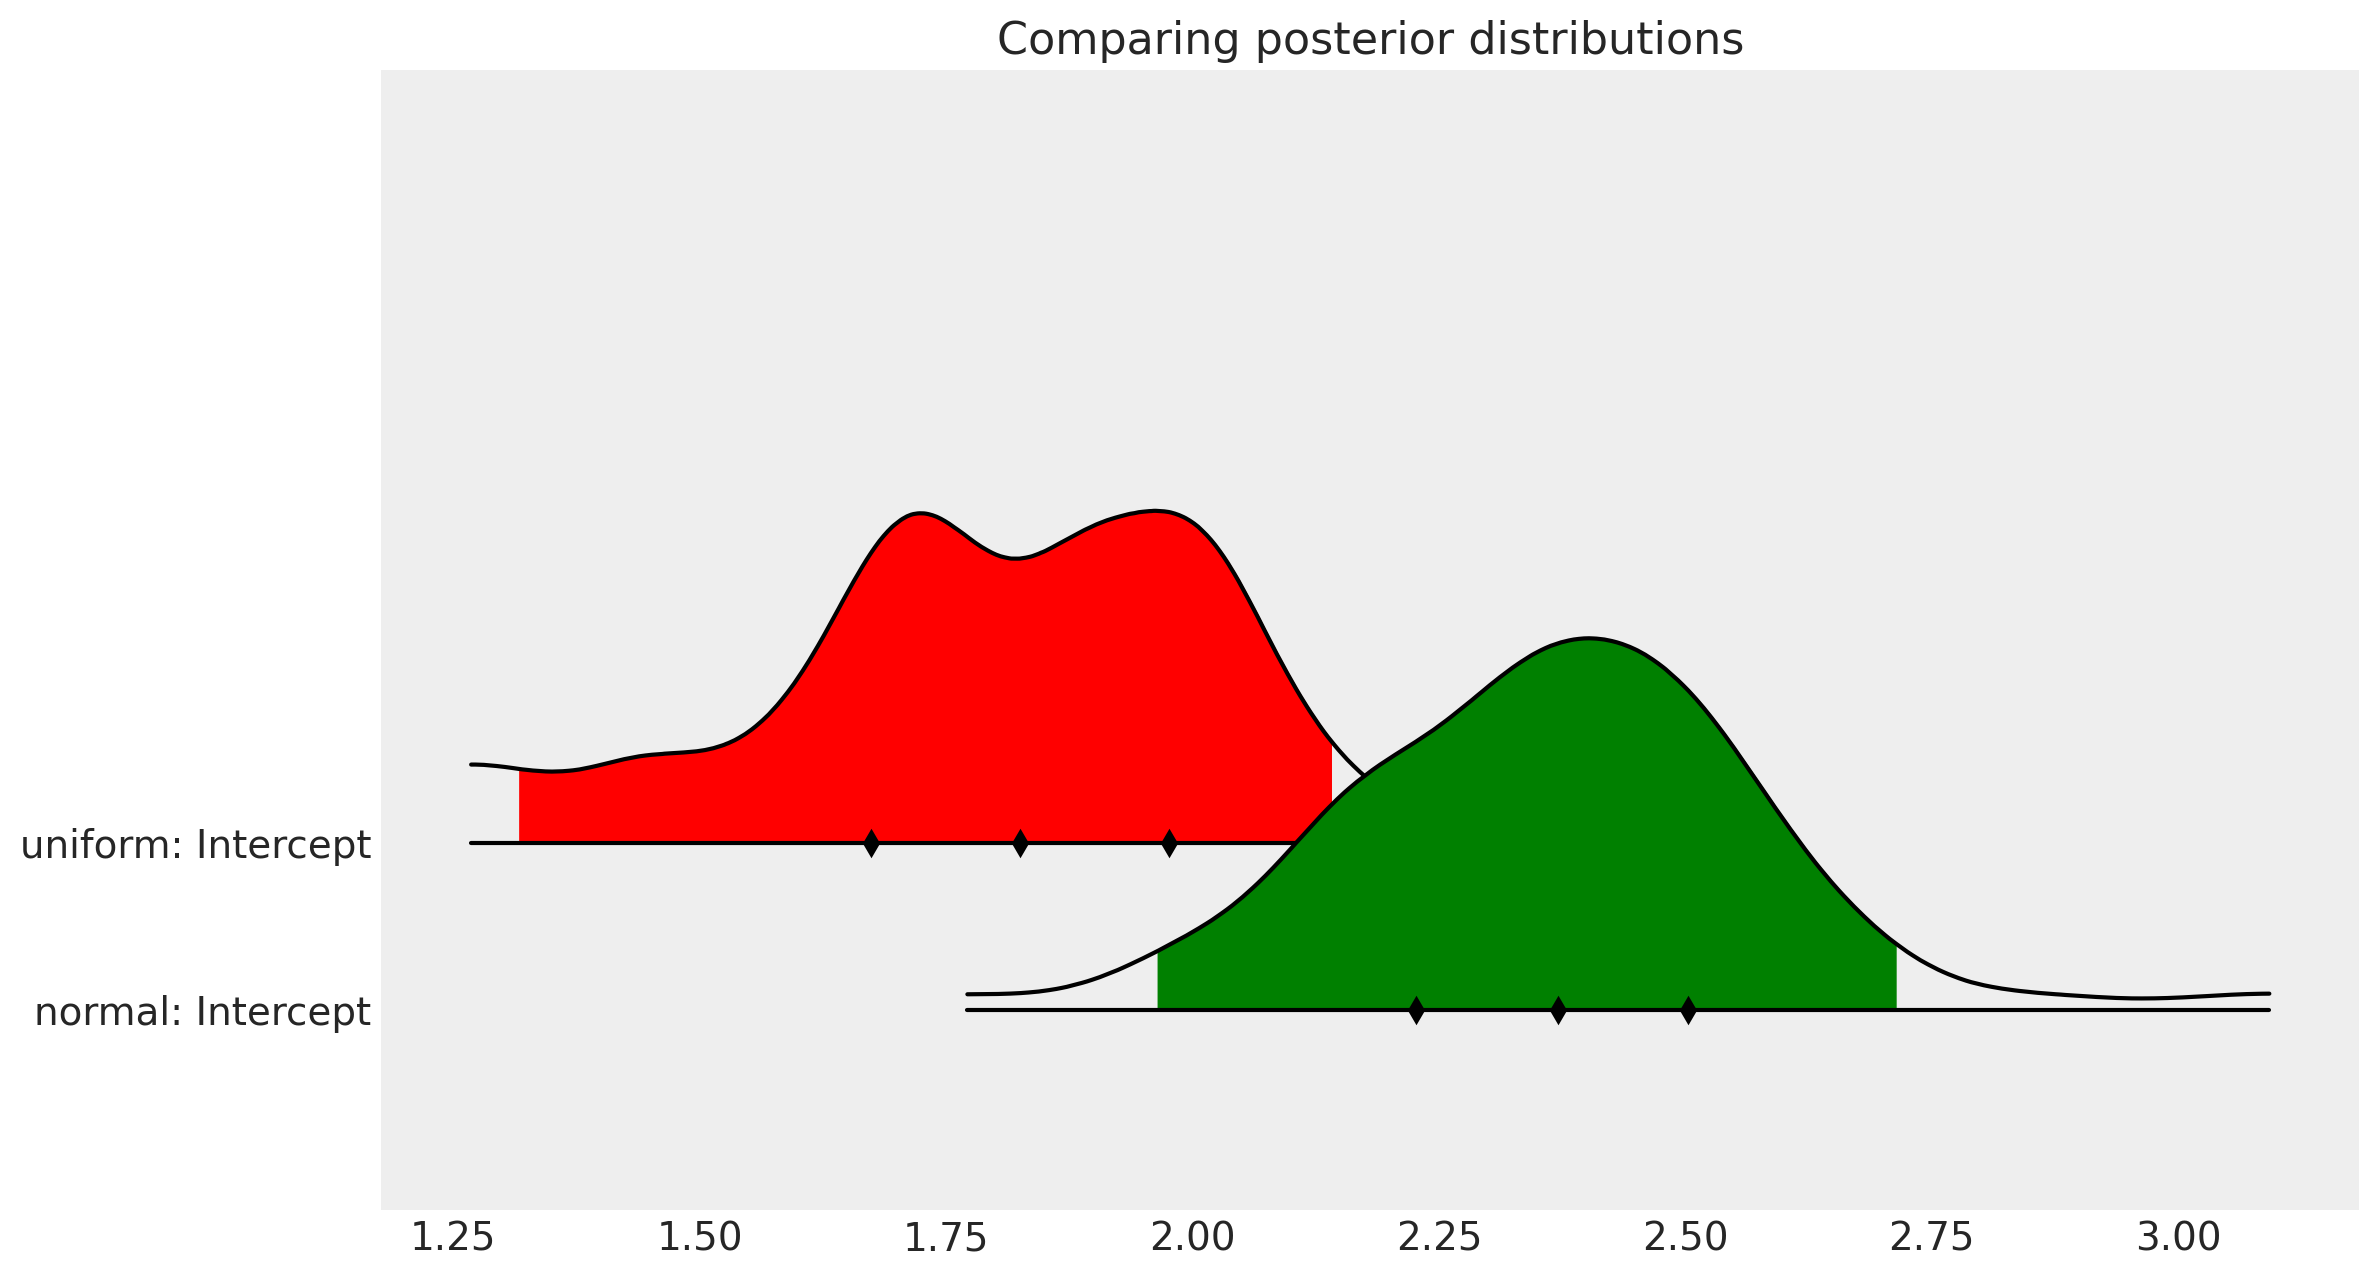

<Figure size 700x700 with 0 Axes>

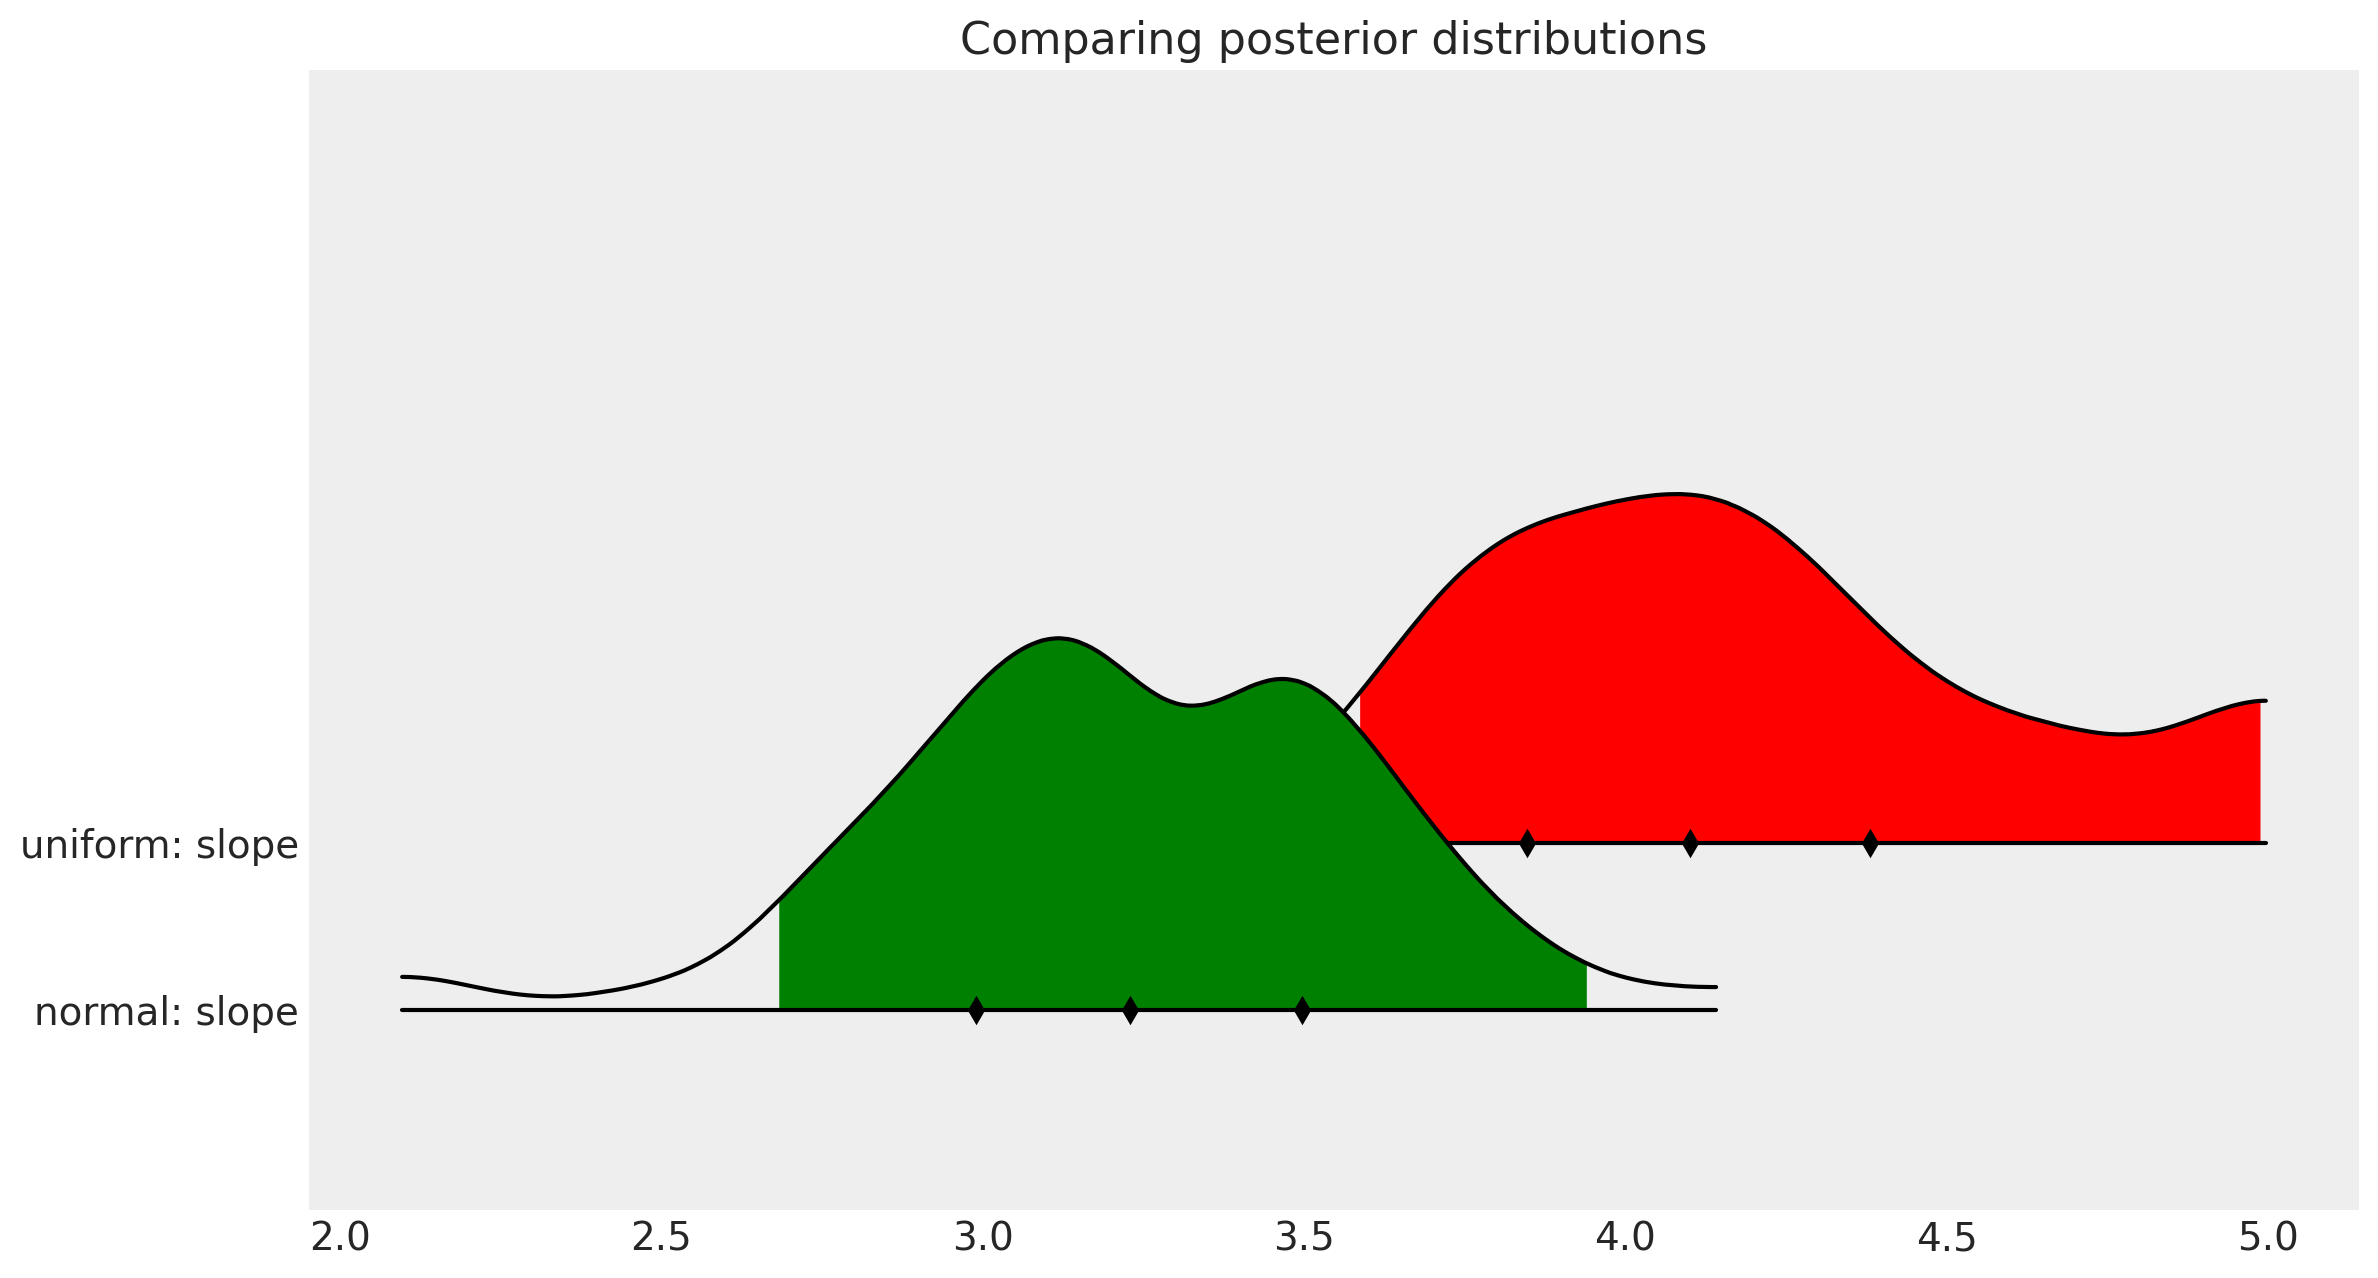

In [17]:
### more examples - comparing posteriors for different prior distributions, low data regime

m_names = ['uniform', 'normal']
traces = []

for i in range(len(m_names)):
    x,y,y_true = generate_data(data_size=10)
    trace = sampler(x,y, chains = 1, prior = m_names[i])
    traces.append(trace)
   
graph_comparisons(traces,m_names)  



Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [slope, Intercept, sigma]
Sampling chain 0, 0 divergences: 100%|██████████| 2200/2200 [00:02<00:00, 1018.22it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [slope, Intercept, sigma]
Sampling chain 0, 0 divergences: 100%|██████████| 2200/2200 [00:02<00:00, 1017.06it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


<Figure size 700x700 with 0 Axes>

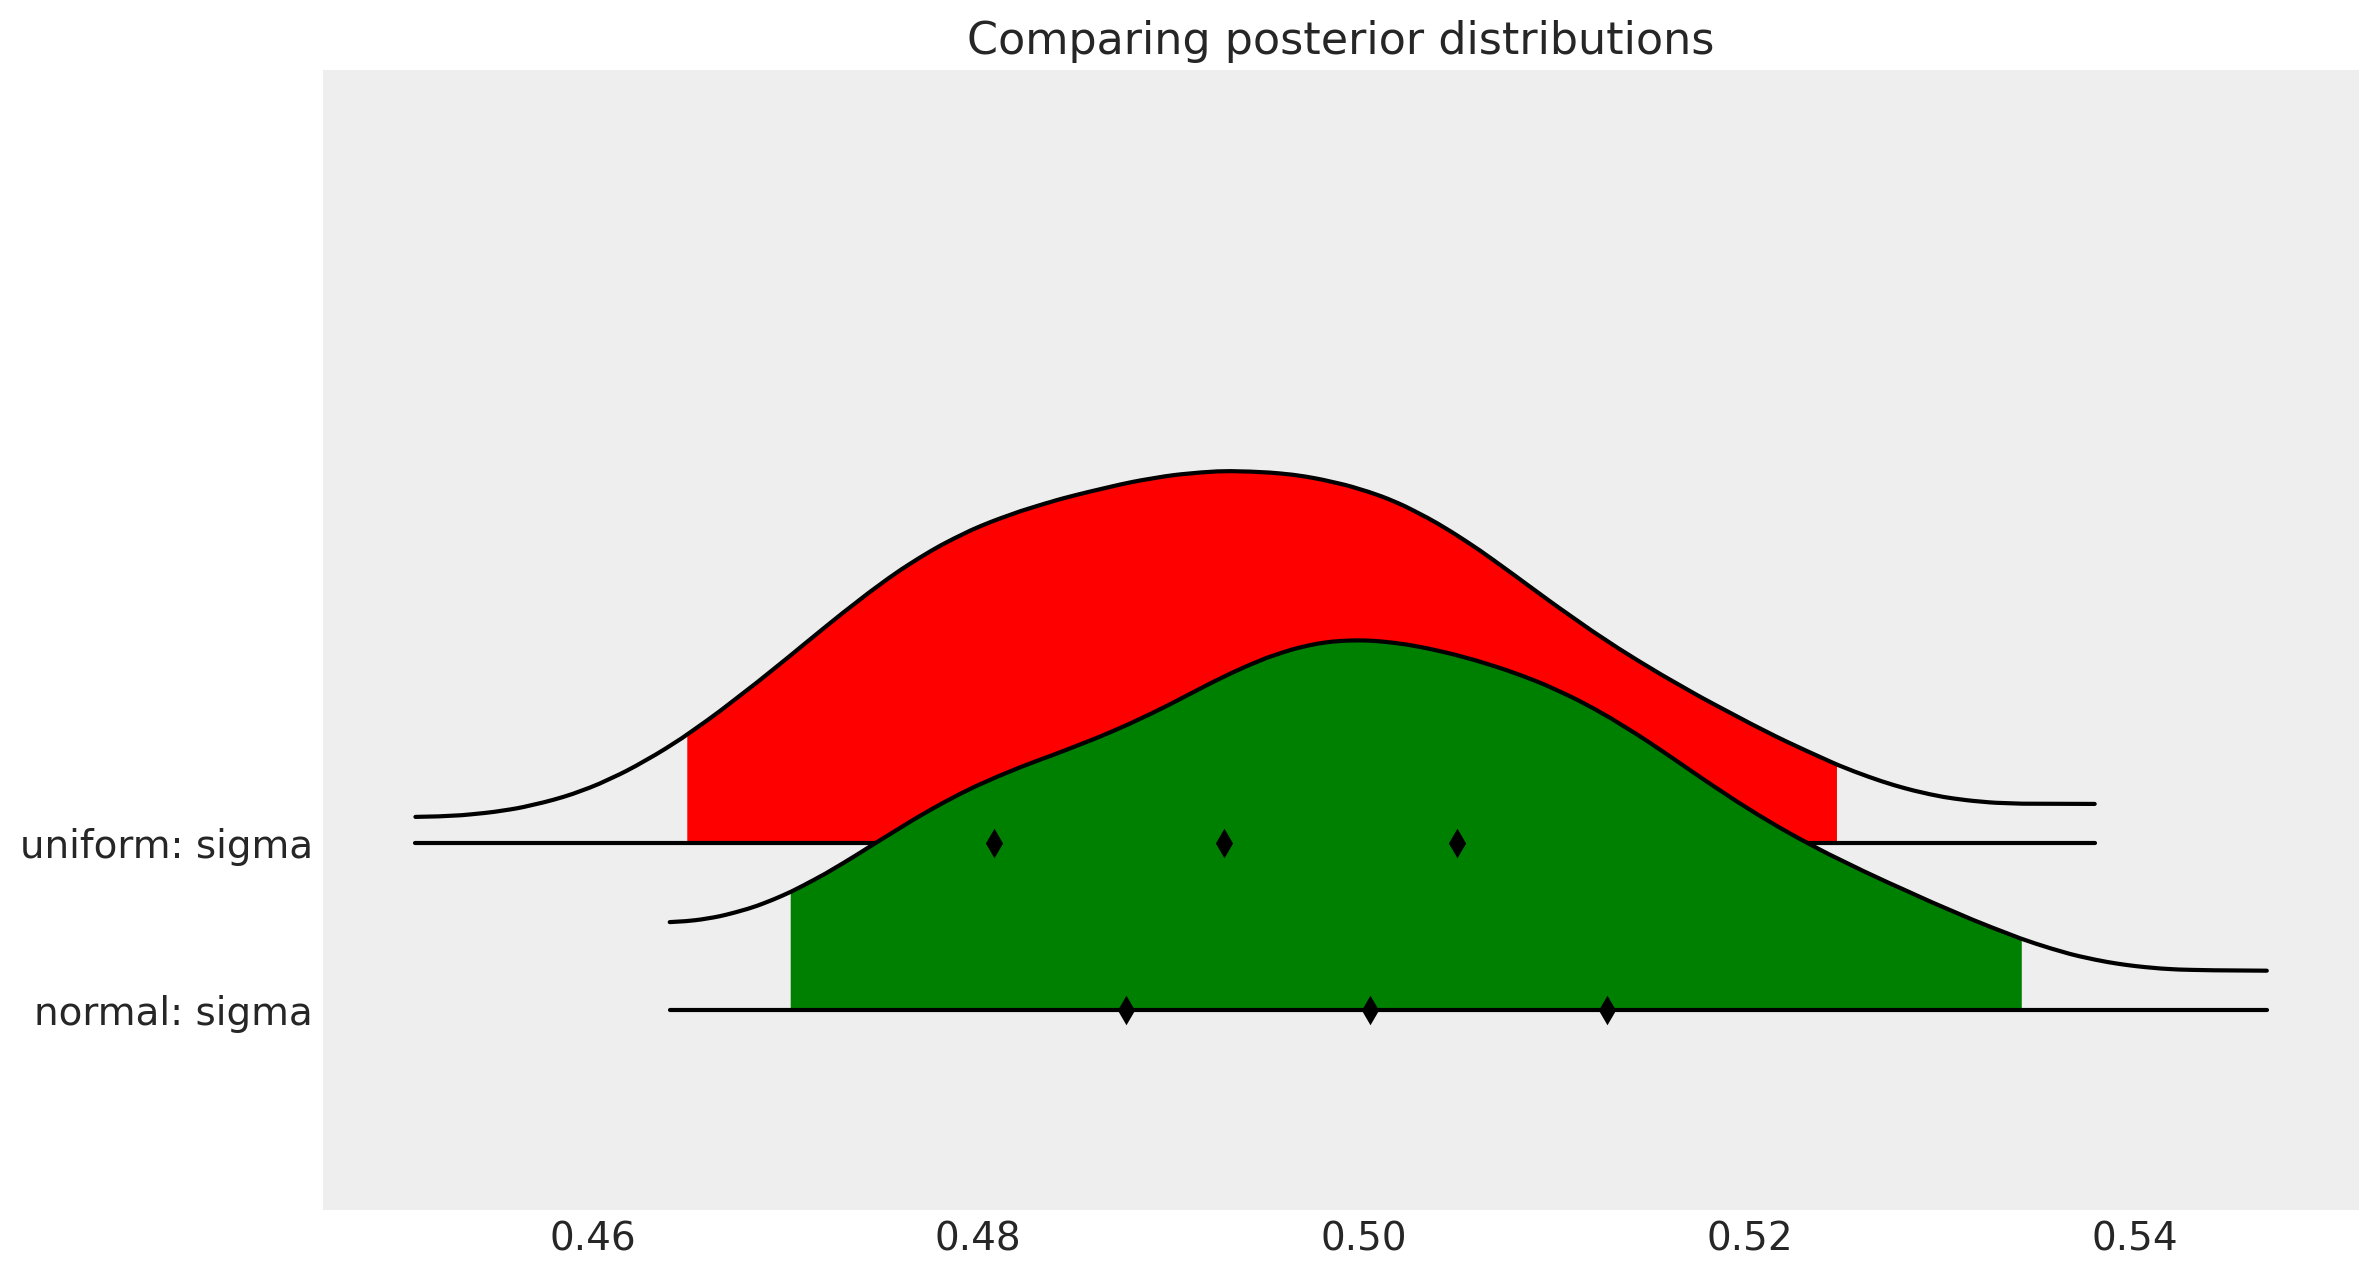

<Figure size 700x700 with 0 Axes>

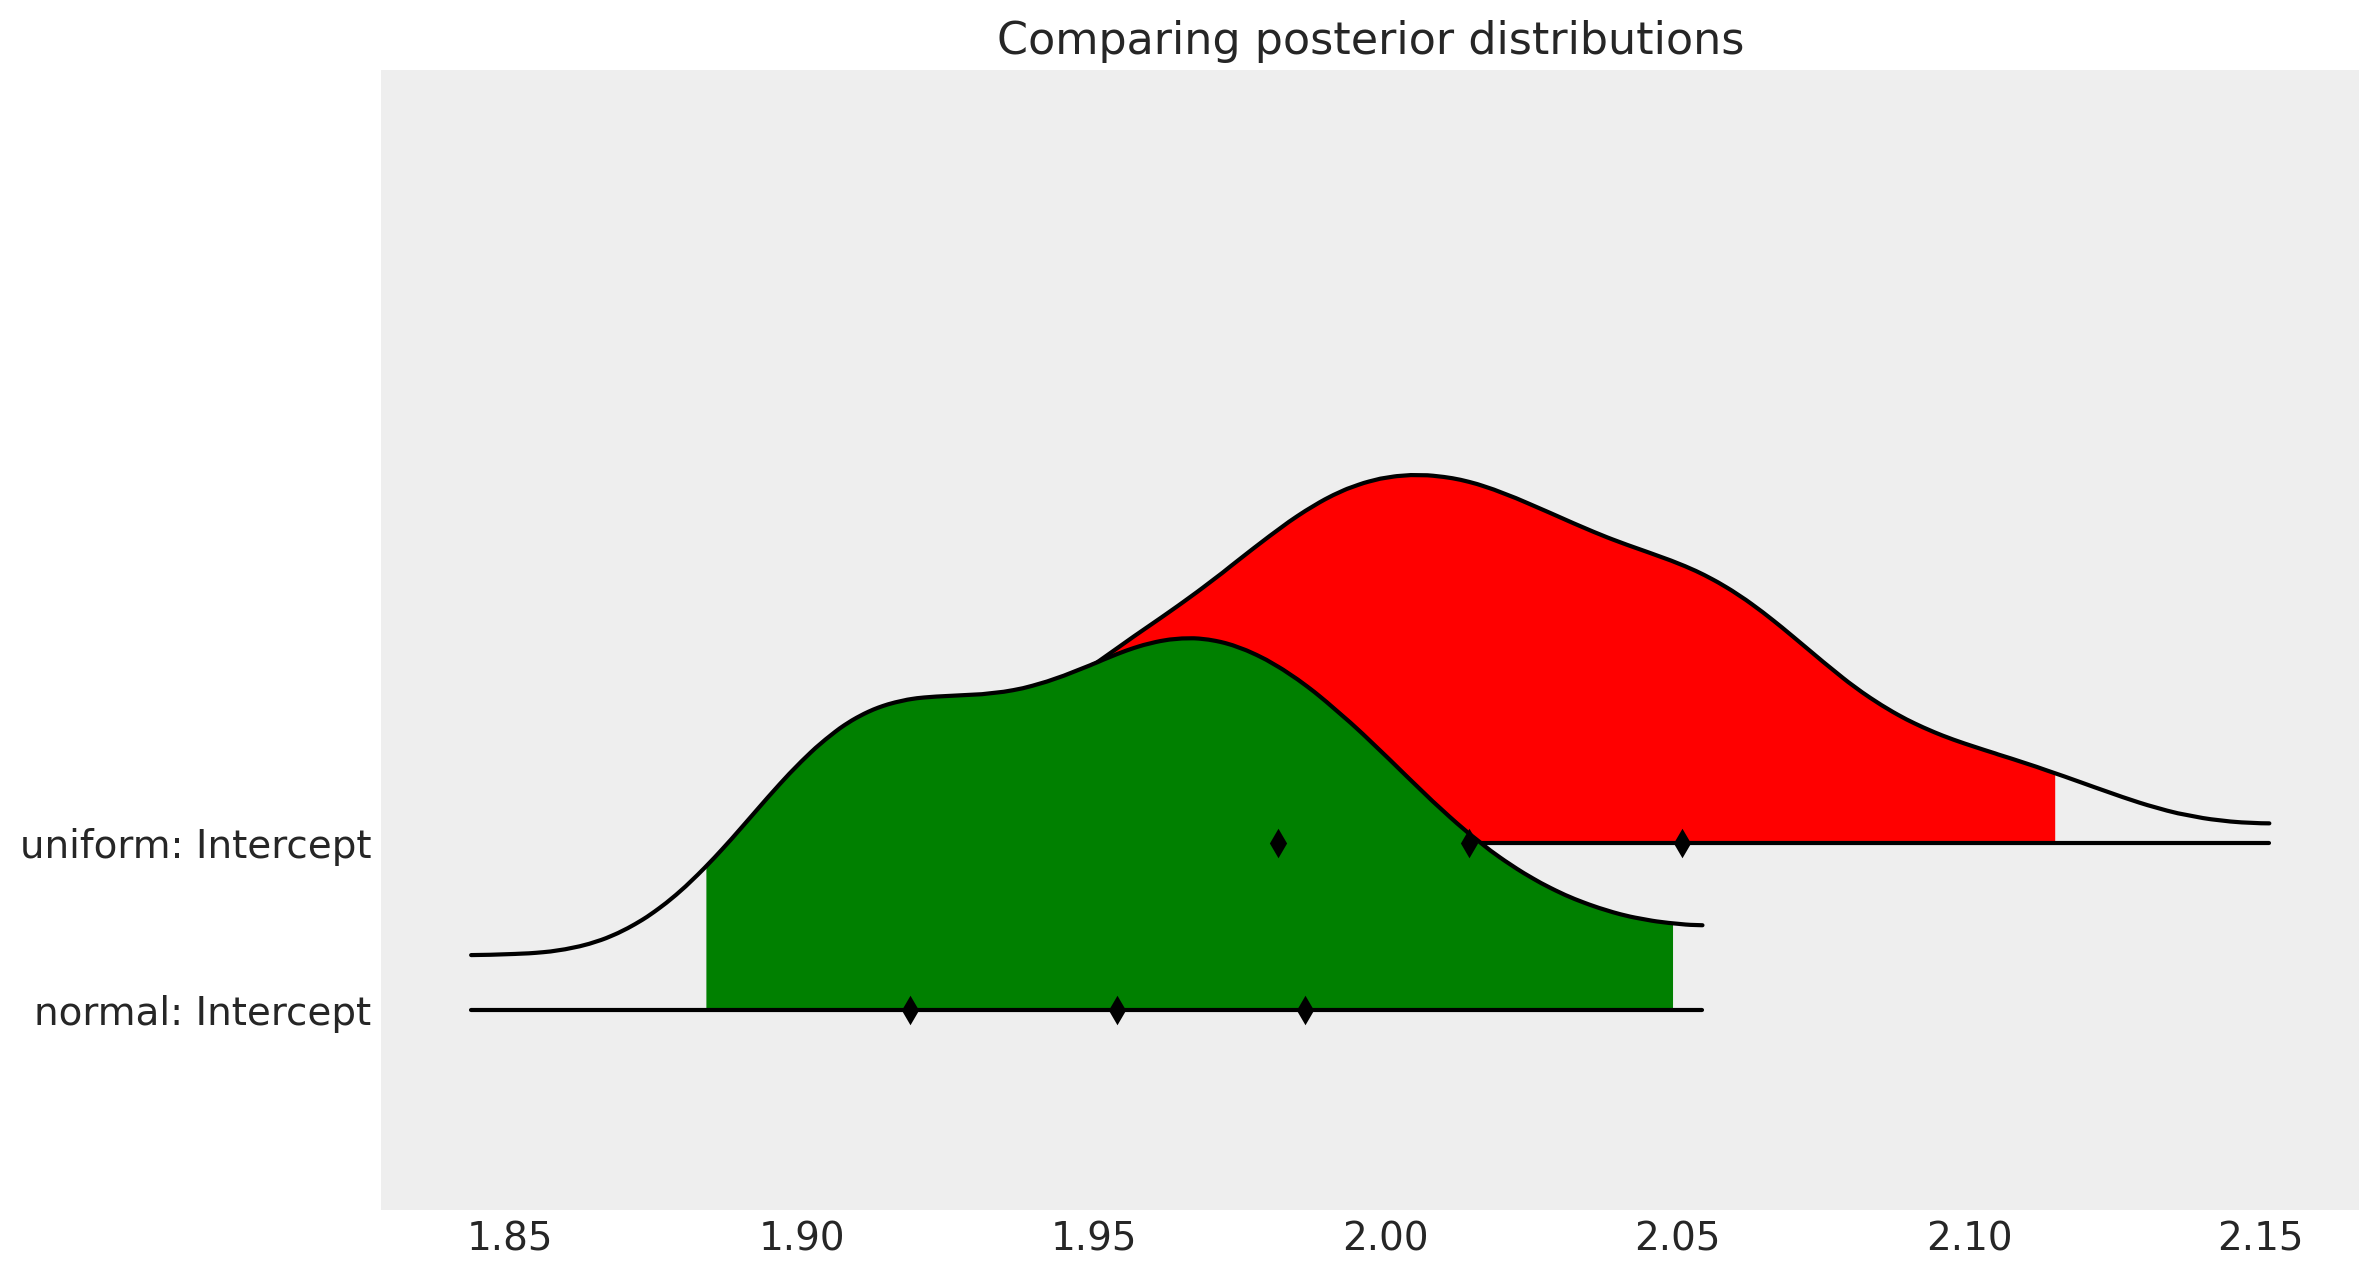

<Figure size 700x700 with 0 Axes>

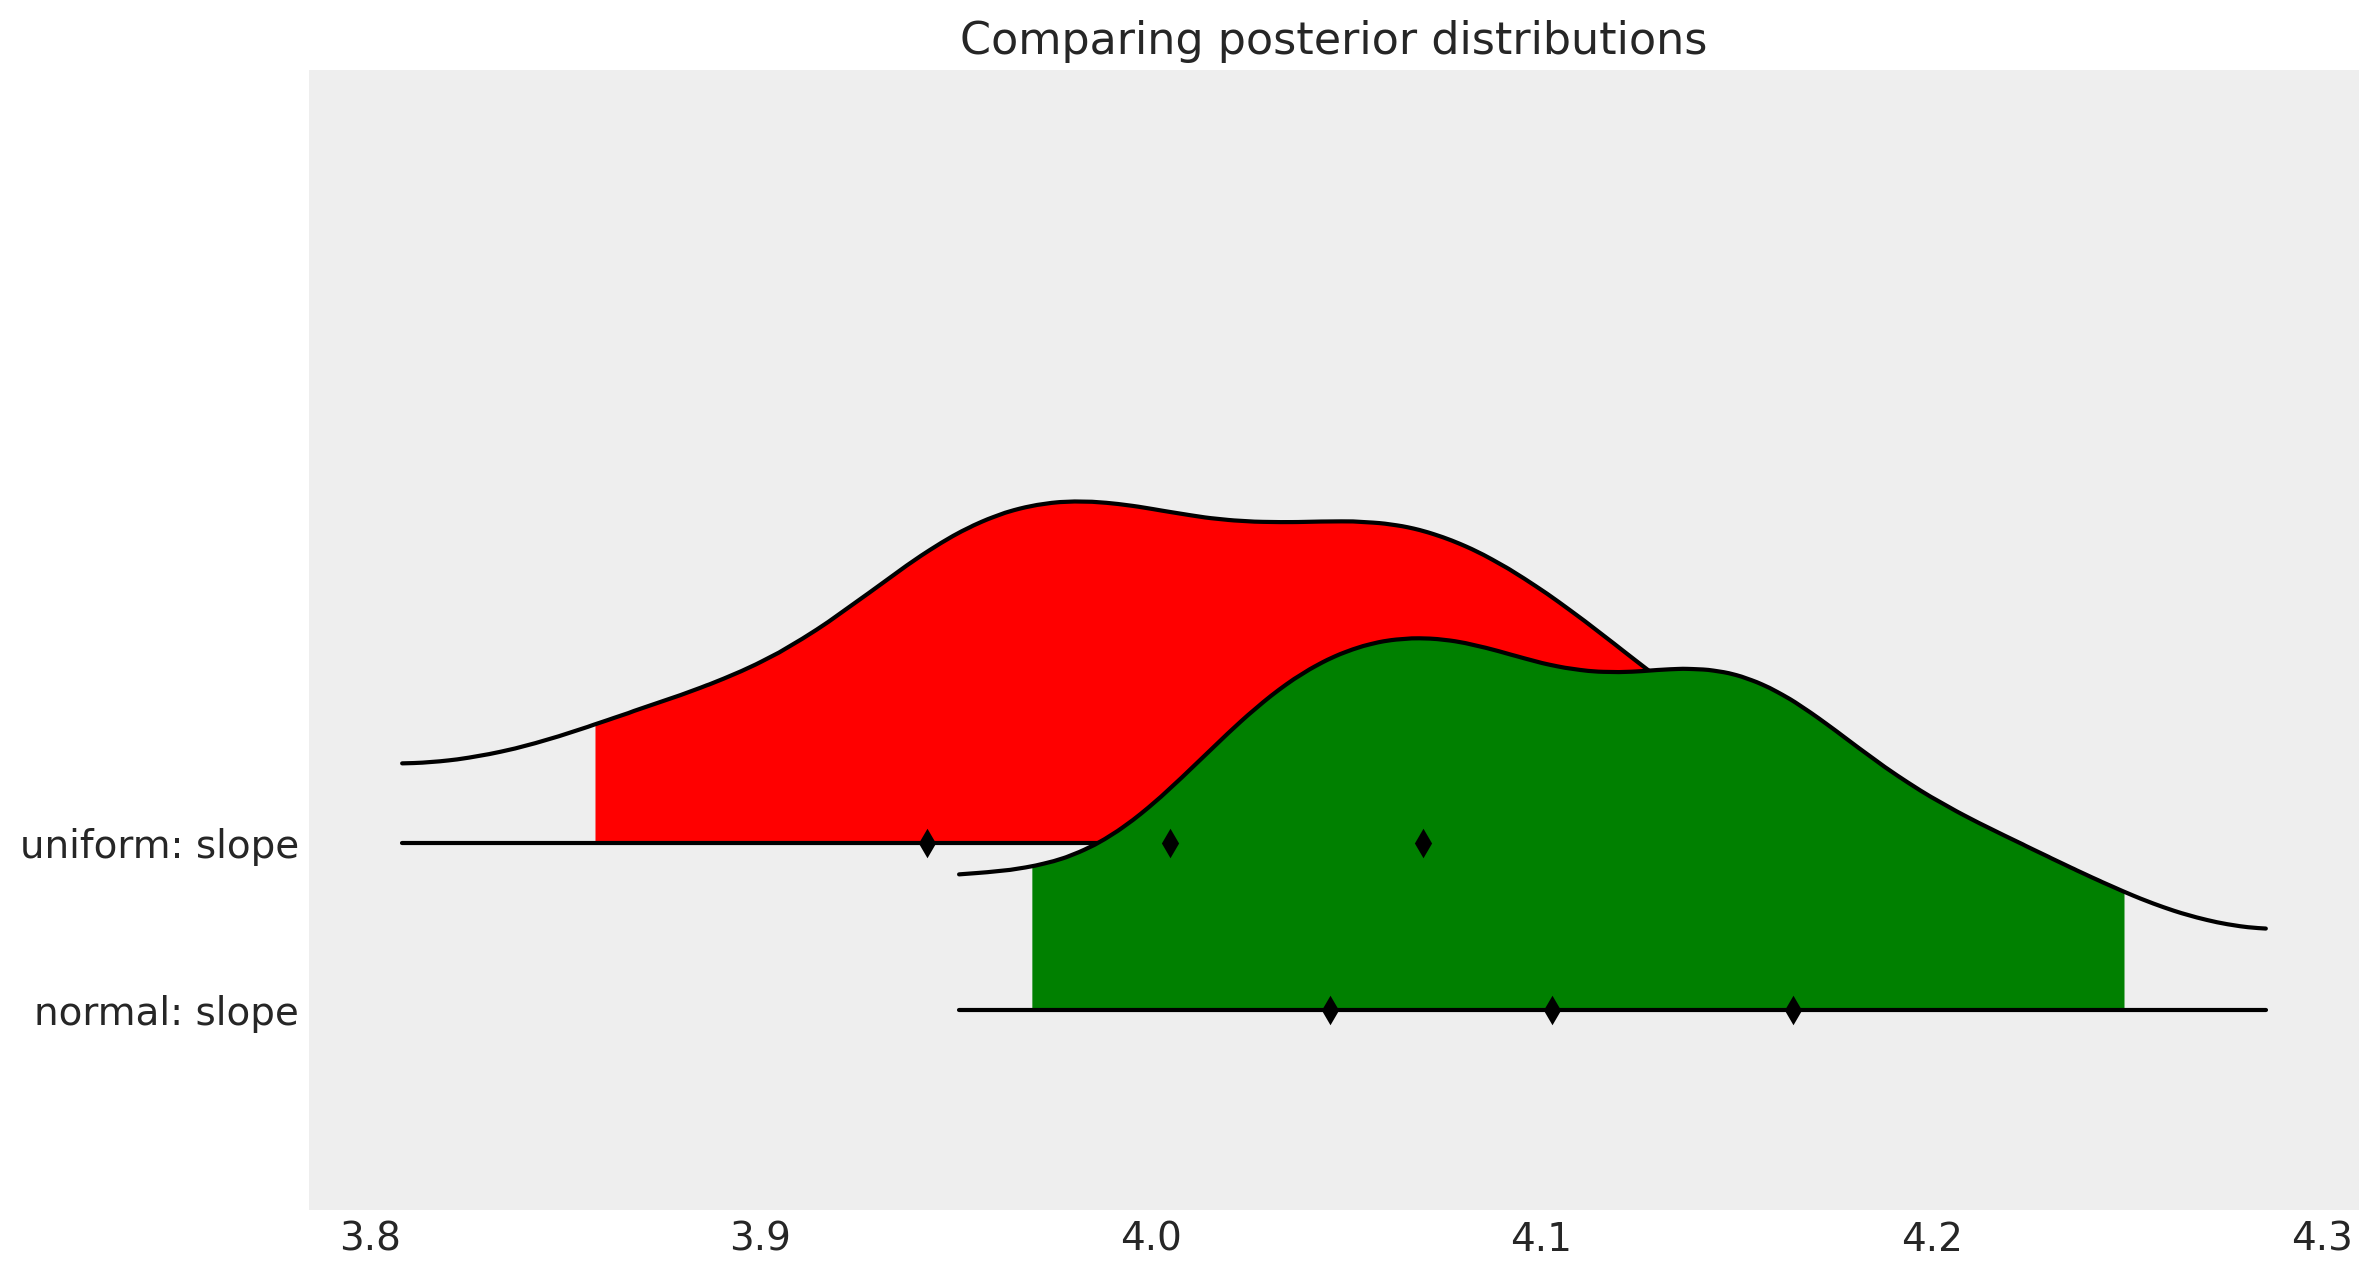

In [18]:
### more examples - comparing posteriors for different prior distributions, large data regime

m_names = ['uniform', 'normal']
traces = []

for i in range(len(m_names)):
    x,y,y_true = generate_data(data_size=500)
    trace = sampler(x,y, chains = 1, prior = m_names[i])
    traces.append(trace)
   
graph_comparisons(traces,m_names)  

In [19]:
### Verifying credible region

# hide output messages from pymc3 (caution: can also hide warnings)
import logging, sys
logging.disable(sys.maxsize)

datasets = []
a = 4 
b = 2
s = 0.5

a_count = 0
b_count = 0
s_count = 0
n = 100
for i in range(n):
    
    if i%10 == 0:
        print(f'iteration {i}')
    
    ### generate dataset
    # data points = 200, slope = 4, intercept = 2, sigma = 0.5, prior -> normal distributions
    
    x,y,y_true = generate_data()
    trace = sampler(x,y, chains = 1, v=False) 
    
    ### calculate credible region (HDI) and check if the true values are inside
    hdi=stats.hpd(trace, hdi_prob=0.95)
    a_low = hdi['slope'][0]
    a_high = hdi['slope'][1]
    b_low = hdi['Intercept'][0]
    b_high = hdi['Intercept'][1]
    s_low = hdi['sigma'][0]
    s_high = hdi['sigma'][1]
    
    if a_low <= a <= a_high:
        a_count += 1 
    if b_low <= b <= b_high:
        b_count += 1 
    if s_low <= s <= s_high:
        s_count += 1 

print(f'slope: {a_count/n}, intercept: {b_count/n}, sigma: {s_count/n}')

iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
slope: 0.9, intercept: 0.9, sigma: 0.92


### Investigating the credible region

We expect that the true parameters will be within the 95% credible region, 95% of the time

To test this we can generate many (100s or 1000s) of datasets and calculate the observed percentage that the true values are within the credibile region. 

In [20]:
# credible region validation
print(f'for {n} data sets: \n  slope: {a_count/n} \n  intercept: {b_count/n} \n  sigma: {s_count/n}')

for 100 data sets: 
  slope: 0.9 
  intercept: 0.9 
  sigma: 0.92
